In [1]:
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, 
    Tracker, make_dataloader, 
    UnsupervisedDataset
)
import jax.random as jrand
import optax
import jax.numpy as jnp
import equinox as eqx

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
# make sure this definition matches exactly (!) the
# definition as it was used in notebook 3
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [4]:
# trained in notebook 3
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model)

# Training a controller

In [5]:
from cc.train import TrainingOptionsController
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect.collect import collect_random_step_source
from cc.env.wrappers import AddRefSignalRewardFnWrapper

source = collect_random_step_source(env, seeds=list(range(30)))
env_w_source = AddRefSignalRewardFnWrapper(env, source)

In [6]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep,
    5,
    f_depth=0
)

In [7]:
controller_dataloader = make_dataloader(
    UnsupervisedDataset(source.get_references_for_optimisation()),
    jrand.PRNGKey(1,),
    n_minibatches=5
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))

controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, 
)

controller_trainer = ModelControllerTrainer(
    fitted_model, controller, controller_train_options=controller_train_options, 
    trackers=[Tracker("train_mse")]
)

In [8]:
controller_trainer.run(500)

  0%|                                                                                                     | 0/500 [00:00<?, ?it/s]

train_loss:    28.0974 | train_mse:    28.0974 | :   0%|                                                  | 0/500 [00:06<?, ?it/s]

train_loss:    28.0974 | train_mse:    28.0974 | :   0%|                                          | 1/500 [00:06<50:02,  6.02s/it]

train_loss:    21.0138 | train_mse:    21.0138 | :   0%|                                          | 1/500 [00:15<50:02,  6.02s/it]

train_loss:    21.0138 | train_mse:    21.0138 | :   0%|▏                                       | 2/500 [00:15<1:08:10,  8.21s/it]

train_loss:    18.4611 | train_mse:    18.4611 | :   0%|▏                                       | 2/500 [00:15<1:08:10,  8.21s/it]

train_loss:    18.4611 | train_mse:    18.4611 | :   1%|▎                                         | 3/500 [00:15<37:26,  4.52s/it]

train_loss:    15.9552 | train_mse:    15.9552 | :   1%|▎                                         | 3/500 [00:16<37:26,  4.52s/it]

train_loss:    15.9552 | train_mse:    15.9552 | :   1%|▎                                         | 4/500 [00:16<23:01,  2.79s/it]

train_loss:    13.5459 | train_mse:    13.5459 | :   1%|▎                                         | 4/500 [00:16<23:01,  2.79s/it]

train_loss:    13.5459 | train_mse:    13.5459 | :   1%|▍                                         | 5/500 [00:16<15:04,  1.83s/it]

train_loss:    11.5023 | train_mse:    11.5023 | :   1%|▍                                         | 5/500 [00:16<15:04,  1.83s/it]

train_loss:    11.5023 | train_mse:    11.5023 | :   1%|▌                                         | 6/500 [00:16<10:16,  1.25s/it]

train_loss:     9.6526 | train_mse:     9.6526 | :   1%|▌                                         | 6/500 [00:16<10:16,  1.25s/it]

train_loss:     9.6526 | train_mse:     9.6526 | :   1%|▌                                         | 7/500 [00:16<07:15,  1.13it/s]

train_loss:     8.1322 | train_mse:     8.1322 | :   1%|▌                                         | 7/500 [00:16<07:15,  1.13it/s]

train_loss:     8.1322 | train_mse:     8.1322 | :   2%|▋                                         | 8/500 [00:16<05:16,  1.56it/s]

train_loss:     6.8322 | train_mse:     6.8322 | :   2%|▋                                         | 8/500 [00:16<05:16,  1.56it/s]

train_loss:     6.8322 | train_mse:     6.8322 | :   2%|▊                                         | 9/500 [00:16<03:56,  2.08it/s]

train_loss:     5.7101 | train_mse:     5.7101 | :   2%|▊                                         | 9/500 [00:16<03:56,  2.08it/s]

train_loss:     5.7101 | train_mse:     5.7101 | :   2%|▊                                        | 10/500 [00:16<03:01,  2.70it/s]

train_loss:     4.8135 | train_mse:     4.8135 | :   2%|▊                                        | 10/500 [00:16<03:01,  2.70it/s]

train_loss:     4.8135 | train_mse:     4.8135 | :   2%|▉                                        | 11/500 [00:16<02:24,  3.39it/s]

train_loss:     4.1028 | train_mse:     4.1028 | :   2%|▉                                        | 11/500 [00:17<02:24,  3.39it/s]

train_loss:     4.1028 | train_mse:     4.1028 | :   2%|▉                                        | 12/500 [00:17<01:58,  4.12it/s]

train_loss:     3.5100 | train_mse:     3.5100 | :   2%|▉                                        | 12/500 [00:17<01:58,  4.12it/s]

train_loss:     3.5100 | train_mse:     3.5100 | :   3%|█                                        | 13/500 [00:17<01:40,  4.83it/s]

train_loss:     3.0620 | train_mse:     3.0620 | :   3%|█                                        | 13/500 [00:17<01:40,  4.83it/s]

train_loss:     3.0620 | train_mse:     3.0620 | :   3%|█▏                                       | 14/500 [00:17<01:28,  5.47it/s]

train_loss:     2.7269 | train_mse:     2.7269 | :   3%|█▏                                       | 14/500 [00:17<01:28,  5.47it/s]

train_loss:     2.7269 | train_mse:     2.7269 | :   3%|█▏                                       | 15/500 [00:17<01:20,  6.03it/s]

train_loss:     2.4660 | train_mse:     2.4660 | :   3%|█▏                                       | 15/500 [00:17<01:20,  6.03it/s]

train_loss:     2.4660 | train_mse:     2.4660 | :   3%|█▎                                       | 16/500 [00:17<01:14,  6.50it/s]

train_loss:     2.2547 | train_mse:     2.2547 | :   3%|█▎                                       | 16/500 [00:17<01:14,  6.50it/s]

train_loss:     2.2547 | train_mse:     2.2547 | :   3%|█▍                                       | 17/500 [00:17<01:10,  6.87it/s]

train_loss:     2.0726 | train_mse:     2.0726 | :   3%|█▍                                       | 17/500 [00:17<01:10,  6.87it/s]

train_loss:     2.0726 | train_mse:     2.0726 | :   4%|█▍                                       | 18/500 [00:17<01:07,  7.16it/s]

train_loss:     1.9162 | train_mse:     1.9162 | :   4%|█▍                                       | 18/500 [00:17<01:07,  7.16it/s]

train_loss:     1.9162 | train_mse:     1.9162 | :   4%|█▌                                       | 19/500 [00:17<01:05,  7.38it/s]

train_loss:     1.8021 | train_mse:     1.8021 | :   4%|█▌                                       | 19/500 [00:18<01:05,  7.38it/s]

train_loss:     1.8021 | train_mse:     1.8021 | :   4%|█▋                                       | 20/500 [00:18<01:03,  7.55it/s]

train_loss:     1.6833 | train_mse:     1.6833 | :   4%|█▋                                       | 20/500 [00:18<01:03,  7.55it/s]

train_loss:     1.6833 | train_mse:     1.6833 | :   4%|█▋                                       | 21/500 [00:18<01:02,  7.66it/s]

train_loss:     1.6001 | train_mse:     1.6001 | :   4%|█▋                                       | 21/500 [00:18<01:02,  7.66it/s]

train_loss:     1.6001 | train_mse:     1.6001 | :   4%|█▊                                       | 22/500 [00:18<01:01,  7.74it/s]

train_loss:     1.5181 | train_mse:     1.5181 | :   4%|█▊                                       | 22/500 [00:18<01:01,  7.74it/s]

train_loss:     1.5181 | train_mse:     1.5181 | :   5%|█▉                                       | 23/500 [00:18<01:01,  7.78it/s]

train_loss:     1.4460 | train_mse:     1.4460 | :   5%|█▉                                       | 23/500 [00:18<01:01,  7.78it/s]

train_loss:     1.4460 | train_mse:     1.4460 | :   5%|█▉                                       | 24/500 [00:18<01:00,  7.83it/s]

train_loss:     1.3687 | train_mse:     1.3687 | :   5%|█▉                                       | 24/500 [00:18<01:00,  7.83it/s]

train_loss:     1.3687 | train_mse:     1.3687 | :   5%|██                                       | 25/500 [00:18<01:00,  7.86it/s]

train_loss:     1.2881 | train_mse:     1.2881 | :   5%|██                                       | 25/500 [00:18<01:00,  7.86it/s]

train_loss:     1.2881 | train_mse:     1.2881 | :   5%|██▏                                      | 26/500 [00:18<01:00,  7.88it/s]

train_loss:     1.2315 | train_mse:     1.2315 | :   5%|██▏                                      | 26/500 [00:18<01:00,  7.88it/s]

train_loss:     1.2315 | train_mse:     1.2315 | :   5%|██▏                                      | 27/500 [00:18<00:59,  7.90it/s]

train_loss:     1.1969 | train_mse:     1.1969 | :   5%|██▏                                      | 27/500 [00:19<00:59,  7.90it/s]

train_loss:     1.1969 | train_mse:     1.1969 | :   6%|██▎                                      | 28/500 [00:19<00:59,  7.97it/s]

train_loss:     1.1712 | train_mse:     1.1712 | :   6%|██▎                                      | 28/500 [00:19<00:59,  7.97it/s]

train_loss:     1.1712 | train_mse:     1.1712 | :   6%|██▍                                      | 29/500 [00:19<00:58,  8.03it/s]

train_loss:     1.1573 | train_mse:     1.1573 | :   6%|██▍                                      | 29/500 [00:19<00:58,  8.03it/s]

train_loss:     1.1573 | train_mse:     1.1573 | :   6%|██▍                                      | 30/500 [00:19<00:58,  8.03it/s]

train_loss:     1.1508 | train_mse:     1.1508 | :   6%|██▍                                      | 30/500 [00:19<00:58,  8.03it/s]

train_loss:     1.1508 | train_mse:     1.1508 | :   6%|██▌                                      | 31/500 [00:19<00:58,  8.07it/s]

train_loss:     1.1364 | train_mse:     1.1364 | :   6%|██▌                                      | 31/500 [00:19<00:58,  8.07it/s]

train_loss:     1.1364 | train_mse:     1.1364 | :   6%|██▌                                      | 32/500 [00:19<00:57,  8.11it/s]

train_loss:     1.1421 | train_mse:     1.1421 | :   6%|██▌                                      | 32/500 [00:19<00:57,  8.11it/s]

train_loss:     1.1421 | train_mse:     1.1421 | :   7%|██▋                                      | 33/500 [00:19<00:57,  8.19it/s]

train_loss:     1.0989 | train_mse:     1.0989 | :   7%|██▋                                      | 33/500 [00:19<00:57,  8.19it/s]

train_loss:     1.0989 | train_mse:     1.0989 | :   7%|██▊                                      | 34/500 [00:19<00:56,  8.26it/s]

train_loss:     1.0821 | train_mse:     1.0821 | :   7%|██▊                                      | 34/500 [00:19<00:56,  8.26it/s]

train_loss:     1.0821 | train_mse:     1.0821 | :   7%|██▊                                      | 35/500 [00:19<00:56,  8.28it/s]

train_loss:     1.0687 | train_mse:     1.0687 | :   7%|██▊                                      | 35/500 [00:20<00:56,  8.28it/s]

train_loss:     1.0687 | train_mse:     1.0687 | :   7%|██▉                                      | 36/500 [00:20<00:55,  8.32it/s]

train_loss:     1.0531 | train_mse:     1.0531 | :   7%|██▉                                      | 36/500 [00:20<00:55,  8.32it/s]

train_loss:     1.0531 | train_mse:     1.0531 | :   7%|███                                      | 37/500 [00:20<00:56,  8.24it/s]

train_loss:     1.0575 | train_mse:     1.0575 | :   7%|███                                      | 37/500 [00:20<00:56,  8.24it/s]

train_loss:     1.0575 | train_mse:     1.0575 | :   8%|███                                      | 38/500 [00:20<00:56,  8.17it/s]

train_loss:     1.0355 | train_mse:     1.0355 | :   8%|███                                      | 38/500 [00:20<00:56,  8.17it/s]

train_loss:     1.0355 | train_mse:     1.0355 | :   8%|███▏                                     | 39/500 [00:20<00:56,  8.17it/s]

train_loss:     1.0187 | train_mse:     1.0187 | :   8%|███▏                                     | 39/500 [00:20<00:56,  8.17it/s]

train_loss:     1.0187 | train_mse:     1.0187 | :   8%|███▎                                     | 40/500 [00:20<00:56,  8.15it/s]

train_loss:     1.0092 | train_mse:     1.0092 | :   8%|███▎                                     | 40/500 [00:20<00:56,  8.15it/s]

train_loss:     1.0092 | train_mse:     1.0092 | :   8%|███▎                                     | 41/500 [00:20<00:56,  8.15it/s]

train_loss:     1.0086 | train_mse:     1.0086 | :   8%|███▎                                     | 41/500 [00:20<00:56,  8.15it/s]

train_loss:     1.0086 | train_mse:     1.0086 | :   8%|███▍                                     | 42/500 [00:20<00:56,  8.15it/s]

train_loss:     0.9922 | train_mse:     0.9922 | :   8%|███▍                                     | 42/500 [00:20<00:56,  8.15it/s]

train_loss:     0.9922 | train_mse:     0.9922 | :   9%|███▌                                     | 43/500 [00:20<00:56,  8.14it/s]

train_loss:     0.9879 | train_mse:     0.9879 | :   9%|███▌                                     | 43/500 [00:20<00:56,  8.14it/s]

train_loss:     0.9879 | train_mse:     0.9879 | :   9%|███▌                                     | 44/500 [00:20<00:56,  8.10it/s]

train_loss:     0.9806 | train_mse:     0.9806 | :   9%|███▌                                     | 44/500 [00:21<00:56,  8.10it/s]

train_loss:     0.9806 | train_mse:     0.9806 | :   9%|███▋                                     | 45/500 [00:21<00:56,  8.05it/s]

train_loss:     0.9886 | train_mse:     0.9886 | :   9%|███▋                                     | 45/500 [00:21<00:56,  8.05it/s]

train_loss:     0.9886 | train_mse:     0.9886 | :   9%|███▊                                     | 46/500 [00:21<00:56,  8.00it/s]

train_loss:     0.9808 | train_mse:     0.9808 | :   9%|███▊                                     | 46/500 [00:21<00:56,  8.00it/s]

train_loss:     0.9808 | train_mse:     0.9808 | :   9%|███▊                                     | 47/500 [00:21<00:56,  8.01it/s]

train_loss:     0.9792 | train_mse:     0.9792 | :   9%|███▊                                     | 47/500 [00:21<00:56,  8.01it/s]

train_loss:     0.9792 | train_mse:     0.9792 | :  10%|███▉                                     | 48/500 [00:21<00:56,  7.96it/s]

train_loss:     0.9822 | train_mse:     0.9822 | :  10%|███▉                                     | 48/500 [00:21<00:56,  7.96it/s]

train_loss:     0.9822 | train_mse:     0.9822 | :  10%|████                                     | 49/500 [00:21<00:56,  7.95it/s]

train_loss:     0.9599 | train_mse:     0.9599 | :  10%|████                                     | 49/500 [00:21<00:56,  7.95it/s]

train_loss:     0.9599 | train_mse:     0.9599 | :  10%|████                                     | 50/500 [00:21<00:56,  7.97it/s]

train_loss:     0.9717 | train_mse:     0.9717 | :  10%|████                                     | 50/500 [00:21<00:56,  7.97it/s]

train_loss:     0.9717 | train_mse:     0.9717 | :  10%|████▏                                    | 51/500 [00:21<00:56,  7.97it/s]

train_loss:     0.9610 | train_mse:     0.9610 | :  10%|████▏                                    | 51/500 [00:22<00:56,  7.97it/s]

train_loss:     0.9610 | train_mse:     0.9610 | :  10%|████▎                                    | 52/500 [00:22<00:56,  7.98it/s]

train_loss:     0.9534 | train_mse:     0.9534 | :  10%|████▎                                    | 52/500 [00:22<00:56,  7.98it/s]

train_loss:     0.9534 | train_mse:     0.9534 | :  11%|████▎                                    | 53/500 [00:22<00:55,  8.03it/s]

train_loss:     0.9486 | train_mse:     0.9486 | :  11%|████▎                                    | 53/500 [00:22<00:55,  8.03it/s]

train_loss:     0.9486 | train_mse:     0.9486 | :  11%|████▍                                    | 54/500 [00:22<00:55,  8.07it/s]

train_loss:     0.9515 | train_mse:     0.9515 | :  11%|████▍                                    | 54/500 [00:22<00:55,  8.07it/s]

train_loss:     0.9515 | train_mse:     0.9515 | :  11%|████▌                                    | 55/500 [00:22<00:54,  8.13it/s]

train_loss:     0.9311 | train_mse:     0.9311 | :  11%|████▌                                    | 55/500 [00:22<00:54,  8.13it/s]

train_loss:     0.9311 | train_mse:     0.9311 | :  11%|████▌                                    | 56/500 [00:22<00:53,  8.29it/s]

train_loss:     0.9361 | train_mse:     0.9361 | :  11%|████▌                                    | 56/500 [00:22<00:53,  8.29it/s]

train_loss:     0.9361 | train_mse:     0.9361 | :  11%|████▋                                    | 57/500 [00:22<00:52,  8.51it/s]

train_loss:     0.9434 | train_mse:     0.9434 | :  11%|████▋                                    | 57/500 [00:22<00:52,  8.51it/s]

train_loss:     0.9434 | train_mse:     0.9434 | :  12%|████▊                                    | 58/500 [00:22<00:50,  8.72it/s]

train_loss:     0.9219 | train_mse:     0.9219 | :  12%|████▊                                    | 58/500 [00:22<00:50,  8.72it/s]

train_loss:     0.9219 | train_mse:     0.9219 | :  12%|████▊                                    | 59/500 [00:22<00:50,  8.82it/s]

train_loss:     0.9104 | train_mse:     0.9104 | :  12%|████▊                                    | 59/500 [00:22<00:50,  8.82it/s]

train_loss:     0.9104 | train_mse:     0.9104 | :  12%|████▉                                    | 60/500 [00:22<00:49,  8.96it/s]

train_loss:     0.9081 | train_mse:     0.9081 | :  12%|████▉                                    | 60/500 [00:23<00:49,  8.96it/s]

train_loss:     0.9081 | train_mse:     0.9081 | :  12%|█████                                    | 61/500 [00:23<00:48,  9.12it/s]

train_loss:     0.9022 | train_mse:     0.9022 | :  12%|█████                                    | 61/500 [00:23<00:48,  9.12it/s]

train_loss:     0.9022 | train_mse:     0.9022 | :  12%|█████                                    | 62/500 [00:23<00:47,  9.19it/s]

train_loss:     0.8965 | train_mse:     0.8965 | :  12%|█████                                    | 62/500 [00:23<00:47,  9.19it/s]

train_loss:     0.8965 | train_mse:     0.8965 | :  13%|█████▏                                   | 63/500 [00:23<00:47,  9.23it/s]

train_loss:     0.8972 | train_mse:     0.8972 | :  13%|█████▏                                   | 63/500 [00:23<00:47,  9.23it/s]

train_loss:     0.8972 | train_mse:     0.8972 | :  13%|█████▏                                   | 64/500 [00:23<00:47,  9.24it/s]

train_loss:     0.8920 | train_mse:     0.8920 | :  13%|█████▏                                   | 64/500 [00:23<00:47,  9.24it/s]

train_loss:     0.8920 | train_mse:     0.8920 | :  13%|█████▎                                   | 65/500 [00:23<00:48,  8.91it/s]

train_loss:     0.9014 | train_mse:     0.9014 | :  13%|█████▎                                   | 65/500 [00:23<00:48,  8.91it/s]

train_loss:     0.9014 | train_mse:     0.9014 | :  13%|█████▍                                   | 66/500 [00:23<00:51,  8.46it/s]

train_loss:     0.8971 | train_mse:     0.8971 | :  13%|█████▍                                   | 66/500 [00:23<00:51,  8.46it/s]

train_loss:     0.8971 | train_mse:     0.8971 | :  13%|█████▍                                   | 67/500 [00:23<00:54,  7.98it/s]

train_loss:     0.8903 | train_mse:     0.8903 | :  13%|█████▍                                   | 67/500 [00:23<00:54,  7.98it/s]

train_loss:     0.8903 | train_mse:     0.8903 | :  14%|█████▌                                   | 68/500 [00:23<01:01,  7.07it/s]

train_loss:     0.8872 | train_mse:     0.8872 | :  14%|█████▌                                   | 68/500 [00:24<01:01,  7.07it/s]

train_loss:     0.8872 | train_mse:     0.8872 | :  14%|█████▋                                   | 69/500 [00:24<01:19,  5.43it/s]

train_loss:     0.8931 | train_mse:     0.8931 | :  14%|█████▋                                   | 69/500 [00:24<01:19,  5.43it/s]

train_loss:     0.8931 | train_mse:     0.8931 | :  14%|█████▋                                   | 70/500 [00:24<01:35,  4.49it/s]

train_loss:     0.8972 | train_mse:     0.8972 | :  14%|█████▋                                   | 70/500 [00:24<01:35,  4.49it/s]

train_loss:     0.8972 | train_mse:     0.8972 | :  14%|█████▊                                   | 71/500 [00:24<01:48,  3.94it/s]

train_loss:     0.8785 | train_mse:     0.8785 | :  14%|█████▊                                   | 71/500 [00:25<01:48,  3.94it/s]

train_loss:     0.8785 | train_mse:     0.8785 | :  14%|█████▉                                   | 72/500 [00:25<01:58,  3.62it/s]

train_loss:     0.8920 | train_mse:     0.8920 | :  14%|█████▉                                   | 72/500 [00:25<01:58,  3.62it/s]

train_loss:     0.8920 | train_mse:     0.8920 | :  15%|█████▉                                   | 73/500 [00:25<01:48,  3.93it/s]

train_loss:     0.8830 | train_mse:     0.8830 | :  15%|█████▉                                   | 73/500 [00:25<01:48,  3.93it/s]

train_loss:     0.8830 | train_mse:     0.8830 | :  15%|██████                                   | 74/500 [00:25<01:37,  4.39it/s]

train_loss:     0.8758 | train_mse:     0.8758 | :  15%|██████                                   | 74/500 [00:25<01:37,  4.39it/s]

train_loss:     0.8758 | train_mse:     0.8758 | :  15%|██████▏                                  | 75/500 [00:25<01:28,  4.78it/s]

train_loss:     0.8916 | train_mse:     0.8916 | :  15%|██████▏                                  | 75/500 [00:25<01:28,  4.78it/s]

train_loss:     0.8916 | train_mse:     0.8916 | :  15%|██████▏                                  | 76/500 [00:25<01:31,  4.64it/s]

train_loss:     0.8631 | train_mse:     0.8631 | :  15%|██████▏                                  | 76/500 [00:26<01:31,  4.64it/s]

train_loss:     0.8631 | train_mse:     0.8631 | :  15%|██████▎                                  | 77/500 [00:26<01:26,  4.87it/s]

train_loss:     0.8638 | train_mse:     0.8638 | :  15%|██████▎                                  | 77/500 [00:26<01:26,  4.87it/s]

train_loss:     0.8638 | train_mse:     0.8638 | :  16%|██████▍                                  | 78/500 [00:26<01:35,  4.43it/s]

train_loss:     0.8554 | train_mse:     0.8554 | :  16%|██████▍                                  | 78/500 [00:26<01:35,  4.43it/s]

train_loss:     0.8554 | train_mse:     0.8554 | :  16%|██████▍                                  | 79/500 [00:26<01:29,  4.68it/s]

train_loss:     0.8530 | train_mse:     0.8530 | :  16%|██████▍                                  | 79/500 [00:26<01:29,  4.68it/s]

train_loss:     0.8530 | train_mse:     0.8530 | :  16%|██████▌                                  | 80/500 [00:26<01:25,  4.92it/s]

train_loss:     0.8499 | train_mse:     0.8499 | :  16%|██████▌                                  | 80/500 [00:26<01:25,  4.92it/s]

train_loss:     0.8499 | train_mse:     0.8499 | :  16%|██████▋                                  | 81/500 [00:26<01:22,  5.09it/s]

train_loss:     0.8452 | train_mse:     0.8452 | :  16%|██████▋                                  | 81/500 [00:27<01:22,  5.09it/s]

train_loss:     0.8452 | train_mse:     0.8452 | :  16%|██████▋                                  | 82/500 [00:27<01:18,  5.30it/s]

train_loss:     0.8372 | train_mse:     0.8372 | :  16%|██████▋                                  | 82/500 [00:27<01:18,  5.30it/s]

train_loss:     0.8372 | train_mse:     0.8372 | :  17%|██████▊                                  | 83/500 [00:27<01:18,  5.34it/s]

train_loss:     0.8360 | train_mse:     0.8360 | :  17%|██████▊                                  | 83/500 [00:27<01:18,  5.34it/s]

train_loss:     0.8360 | train_mse:     0.8360 | :  17%|██████▉                                  | 84/500 [00:27<01:20,  5.15it/s]

train_loss:     0.8337 | train_mse:     0.8337 | :  17%|██████▉                                  | 84/500 [00:27<01:20,  5.15it/s]

train_loss:     0.8337 | train_mse:     0.8337 | :  17%|██████▉                                  | 85/500 [00:27<01:18,  5.26it/s]

train_loss:     0.8321 | train_mse:     0.8321 | :  17%|██████▉                                  | 85/500 [00:27<01:18,  5.26it/s]

train_loss:     0.8321 | train_mse:     0.8321 | :  17%|███████                                  | 86/500 [00:27<01:13,  5.62it/s]

train_loss:     0.8284 | train_mse:     0.8284 | :  17%|███████                                  | 86/500 [00:27<01:13,  5.62it/s]

train_loss:     0.8284 | train_mse:     0.8284 | :  17%|███████▏                                 | 87/500 [00:27<01:09,  5.93it/s]

train_loss:     0.8243 | train_mse:     0.8243 | :  17%|███████▏                                 | 87/500 [00:28<01:09,  5.93it/s]

train_loss:     0.8243 | train_mse:     0.8243 | :  18%|███████▏                                 | 88/500 [00:28<01:10,  5.87it/s]

train_loss:     0.8230 | train_mse:     0.8230 | :  18%|███████▏                                 | 88/500 [00:28<01:10,  5.87it/s]

train_loss:     0.8230 | train_mse:     0.8230 | :  18%|███████▎                                 | 89/500 [00:28<01:07,  6.07it/s]

train_loss:     0.8231 | train_mse:     0.8231 | :  18%|███████▎                                 | 89/500 [00:28<01:07,  6.07it/s]

train_loss:     0.8231 | train_mse:     0.8231 | :  18%|███████▍                                 | 90/500 [00:28<01:06,  6.20it/s]

train_loss:     0.8252 | train_mse:     0.8252 | :  18%|███████▍                                 | 90/500 [00:28<01:06,  6.20it/s]

train_loss:     0.8252 | train_mse:     0.8252 | :  18%|███████▍                                 | 91/500 [00:28<01:04,  6.35it/s]

train_loss:     0.8449 | train_mse:     0.8449 | :  18%|███████▍                                 | 91/500 [00:28<01:04,  6.35it/s]

train_loss:     0.8449 | train_mse:     0.8449 | :  18%|███████▌                                 | 92/500 [00:28<01:03,  6.40it/s]

train_loss:     0.8268 | train_mse:     0.8268 | :  18%|███████▌                                 | 92/500 [00:28<01:03,  6.40it/s]

train_loss:     0.8268 | train_mse:     0.8268 | :  19%|███████▋                                 | 93/500 [00:28<01:02,  6.49it/s]

train_loss:     0.8218 | train_mse:     0.8218 | :  19%|███████▋                                 | 93/500 [00:29<01:02,  6.49it/s]

train_loss:     0.8218 | train_mse:     0.8218 | :  19%|███████▋                                 | 94/500 [00:29<01:04,  6.34it/s]

train_loss:     0.8674 | train_mse:     0.8674 | :  19%|███████▋                                 | 94/500 [00:29<01:04,  6.34it/s]

train_loss:     0.8674 | train_mse:     0.8674 | :  19%|███████▊                                 | 95/500 [00:29<01:03,  6.34it/s]

train_loss:     0.8469 | train_mse:     0.8469 | :  19%|███████▊                                 | 95/500 [00:29<01:03,  6.34it/s]

train_loss:     0.8469 | train_mse:     0.8469 | :  19%|███████▊                                 | 96/500 [00:29<01:09,  5.83it/s]

train_loss:     0.8304 | train_mse:     0.8304 | :  19%|███████▊                                 | 96/500 [00:29<01:09,  5.83it/s]

train_loss:     0.8304 | train_mse:     0.8304 | :  19%|███████▉                                 | 97/500 [00:29<01:06,  6.03it/s]

train_loss:     0.8199 | train_mse:     0.8199 | :  19%|███████▉                                 | 97/500 [00:29<01:06,  6.03it/s]

train_loss:     0.8199 | train_mse:     0.8199 | :  20%|████████                                 | 98/500 [00:29<01:05,  6.11it/s]

train_loss:     0.8167 | train_mse:     0.8167 | :  20%|████████                                 | 98/500 [00:29<01:05,  6.11it/s]

train_loss:     0.8167 | train_mse:     0.8167 | :  20%|████████                                 | 99/500 [00:29<01:04,  6.18it/s]

train_loss:     0.8161 | train_mse:     0.8161 | :  20%|████████                                 | 99/500 [00:30<01:04,  6.18it/s]

train_loss:     0.8161 | train_mse:     0.8161 | :  20%|████████                                | 100/500 [00:30<01:02,  6.36it/s]

train_loss:     0.8167 | train_mse:     0.8167 | :  20%|████████                                | 100/500 [00:30<01:02,  6.36it/s]

train_loss:     0.8167 | train_mse:     0.8167 | :  20%|████████                                | 101/500 [00:30<01:01,  6.47it/s]

train_loss:     0.8198 | train_mse:     0.8198 | :  20%|████████                                | 101/500 [00:30<01:01,  6.47it/s]

train_loss:     0.8198 | train_mse:     0.8198 | :  20%|████████▏                               | 102/500 [00:30<01:02,  6.34it/s]

train_loss:     0.8135 | train_mse:     0.8135 | :  20%|████████▏                               | 102/500 [00:30<01:02,  6.34it/s]

train_loss:     0.8135 | train_mse:     0.8135 | :  21%|████████▏                               | 103/500 [00:30<01:01,  6.50it/s]

train_loss:     0.8130 | train_mse:     0.8130 | :  21%|████████▏                               | 103/500 [00:30<01:01,  6.50it/s]

train_loss:     0.8130 | train_mse:     0.8130 | :  21%|████████▎                               | 104/500 [00:30<00:59,  6.62it/s]

train_loss:     0.8037 | train_mse:     0.8037 | :  21%|████████▎                               | 104/500 [00:30<00:59,  6.62it/s]

train_loss:     0.8037 | train_mse:     0.8037 | :  21%|████████▍                               | 105/500 [00:30<00:58,  6.73it/s]

train_loss:     0.8112 | train_mse:     0.8112 | :  21%|████████▍                               | 105/500 [00:30<00:58,  6.73it/s]

train_loss:     0.8112 | train_mse:     0.8112 | :  21%|████████▍                               | 106/500 [00:30<00:58,  6.71it/s]

train_loss:     0.8024 | train_mse:     0.8024 | :  21%|████████▍                               | 106/500 [00:31<00:58,  6.71it/s]

train_loss:     0.8024 | train_mse:     0.8024 | :  21%|████████▌                               | 107/500 [00:31<00:59,  6.60it/s]

train_loss:     0.7963 | train_mse:     0.7963 | :  21%|████████▌                               | 107/500 [00:31<00:59,  6.60it/s]

train_loss:     0.7963 | train_mse:     0.7963 | :  22%|████████▋                               | 108/500 [00:31<01:07,  5.81it/s]

train_loss:     0.8089 | train_mse:     0.8089 | :  22%|████████▋                               | 108/500 [00:31<01:07,  5.81it/s]

train_loss:     0.8089 | train_mse:     0.8089 | :  22%|████████▋                               | 109/500 [00:31<01:06,  5.85it/s]

train_loss:     0.7895 | train_mse:     0.7895 | :  22%|████████▋                               | 109/500 [00:31<01:06,  5.85it/s]

train_loss:     0.7895 | train_mse:     0.7895 | :  22%|████████▊                               | 110/500 [00:31<01:05,  5.99it/s]

train_loss:     0.8054 | train_mse:     0.8054 | :  22%|████████▊                               | 110/500 [00:31<01:05,  5.99it/s]

train_loss:     0.8054 | train_mse:     0.8054 | :  22%|████████▉                               | 111/500 [00:31<01:03,  6.09it/s]

train_loss:     0.7966 | train_mse:     0.7966 | :  22%|████████▉                               | 111/500 [00:31<01:03,  6.09it/s]

train_loss:     0.7966 | train_mse:     0.7966 | :  22%|████████▉                               | 112/500 [00:31<01:02,  6.16it/s]

train_loss:     0.8039 | train_mse:     0.8039 | :  22%|████████▉                               | 112/500 [00:32<01:02,  6.16it/s]

train_loss:     0.8039 | train_mse:     0.8039 | :  23%|█████████                               | 113/500 [00:32<01:04,  6.01it/s]

train_loss:     0.7918 | train_mse:     0.7918 | :  23%|█████████                               | 113/500 [00:32<01:04,  6.01it/s]

train_loss:     0.7918 | train_mse:     0.7918 | :  23%|█████████                               | 114/500 [00:32<01:06,  5.82it/s]

train_loss:     0.7844 | train_mse:     0.7844 | :  23%|█████████                               | 114/500 [00:32<01:06,  5.82it/s]

train_loss:     0.7844 | train_mse:     0.7844 | :  23%|█████████▏                              | 115/500 [00:32<01:03,  6.03it/s]

train_loss:     0.7785 | train_mse:     0.7785 | :  23%|█████████▏                              | 115/500 [00:32<01:03,  6.03it/s]

train_loss:     0.7785 | train_mse:     0.7785 | :  23%|█████████▎                              | 116/500 [00:32<01:04,  5.93it/s]

train_loss:     0.8063 | train_mse:     0.8063 | :  23%|█████████▎                              | 116/500 [00:32<01:04,  5.93it/s]

train_loss:     0.8063 | train_mse:     0.8063 | :  23%|█████████▎                              | 117/500 [00:32<01:04,  5.93it/s]

train_loss:     0.7921 | train_mse:     0.7921 | :  23%|█████████▎                              | 117/500 [00:33<01:04,  5.93it/s]

train_loss:     0.7921 | train_mse:     0.7921 | :  24%|█████████▍                              | 118/500 [00:33<01:10,  5.43it/s]

train_loss:     0.7915 | train_mse:     0.7915 | :  24%|█████████▍                              | 118/500 [00:33<01:10,  5.43it/s]

train_loss:     0.7915 | train_mse:     0.7915 | :  24%|█████████▌                              | 119/500 [00:33<01:07,  5.61it/s]

train_loss:     0.7963 | train_mse:     0.7963 | :  24%|█████████▌                              | 119/500 [00:33<01:07,  5.61it/s]

train_loss:     0.7963 | train_mse:     0.7963 | :  24%|█████████▌                              | 120/500 [00:33<01:07,  5.65it/s]

train_loss:     0.7831 | train_mse:     0.7831 | :  24%|█████████▌                              | 120/500 [00:33<01:07,  5.65it/s]

train_loss:     0.7831 | train_mse:     0.7831 | :  24%|█████████▋                              | 121/500 [00:33<01:16,  4.98it/s]

train_loss:     0.7833 | train_mse:     0.7833 | :  24%|█████████▋                              | 121/500 [00:33<01:16,  4.98it/s]

train_loss:     0.7833 | train_mse:     0.7833 | :  24%|█████████▊                              | 122/500 [00:33<01:18,  4.83it/s]

train_loss:     0.7766 | train_mse:     0.7766 | :  24%|█████████▊                              | 122/500 [00:34<01:18,  4.83it/s]

train_loss:     0.7766 | train_mse:     0.7766 | :  25%|█████████▊                              | 123/500 [00:34<01:18,  4.78it/s]

train_loss:     0.8032 | train_mse:     0.8032 | :  25%|█████████▊                              | 123/500 [00:34<01:18,  4.78it/s]

train_loss:     0.8032 | train_mse:     0.8032 | :  25%|█████████▉                              | 124/500 [00:34<01:14,  5.03it/s]

train_loss:     0.8434 | train_mse:     0.8434 | :  25%|█████████▉                              | 124/500 [00:34<01:14,  5.03it/s]

train_loss:     0.8434 | train_mse:     0.8434 | :  25%|██████████                              | 125/500 [00:34<01:11,  5.27it/s]

train_loss:     0.7746 | train_mse:     0.7746 | :  25%|██████████                              | 125/500 [00:34<01:11,  5.27it/s]

train_loss:     0.7746 | train_mse:     0.7746 | :  25%|██████████                              | 126/500 [00:34<01:08,  5.45it/s]

train_loss:     0.8320 | train_mse:     0.8320 | :  25%|██████████                              | 126/500 [00:34<01:08,  5.45it/s]

train_loss:     0.8320 | train_mse:     0.8320 | :  25%|██████████▏                             | 127/500 [00:34<01:07,  5.53it/s]

train_loss:     0.8061 | train_mse:     0.8061 | :  25%|██████████▏                             | 127/500 [00:34<01:07,  5.53it/s]

train_loss:     0.8061 | train_mse:     0.8061 | :  26%|██████████▏                             | 128/500 [00:34<01:06,  5.56it/s]

train_loss:     0.7664 | train_mse:     0.7664 | :  26%|██████████▏                             | 128/500 [00:35<01:06,  5.56it/s]

train_loss:     0.7664 | train_mse:     0.7664 | :  26%|██████████▎                             | 129/500 [00:35<01:08,  5.39it/s]

train_loss:     0.7780 | train_mse:     0.7780 | :  26%|██████████▎                             | 129/500 [00:35<01:08,  5.39it/s]

train_loss:     0.7780 | train_mse:     0.7780 | :  26%|██████████▍                             | 130/500 [00:35<01:09,  5.32it/s]

train_loss:     0.8397 | train_mse:     0.8397 | :  26%|██████████▍                             | 130/500 [00:35<01:09,  5.32it/s]

train_loss:     0.8397 | train_mse:     0.8397 | :  26%|██████████▍                             | 131/500 [00:35<01:11,  5.17it/s]

train_loss:     0.7987 | train_mse:     0.7987 | :  26%|██████████▍                             | 131/500 [00:35<01:11,  5.17it/s]

train_loss:     0.7987 | train_mse:     0.7987 | :  26%|██████████▌                             | 132/500 [00:35<01:16,  4.83it/s]

train_loss:     0.7615 | train_mse:     0.7615 | :  26%|██████████▌                             | 132/500 [00:36<01:16,  4.83it/s]

train_loss:     0.7615 | train_mse:     0.7615 | :  27%|██████████▋                             | 133/500 [00:36<01:22,  4.43it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  27%|██████████▋                             | 133/500 [00:36<01:22,  4.43it/s]

train_loss:     0.7594 | train_mse:     0.7594 | :  27%|██████████▋                             | 134/500 [00:36<01:23,  4.39it/s]

train_loss:     0.7581 | train_mse:     0.7581 | :  27%|██████████▋                             | 134/500 [00:36<01:23,  4.39it/s]

train_loss:     0.7581 | train_mse:     0.7581 | :  27%|██████████▊                             | 135/500 [00:36<01:26,  4.21it/s]

train_loss:     0.7562 | train_mse:     0.7562 | :  27%|██████████▊                             | 135/500 [00:36<01:26,  4.21it/s]

train_loss:     0.7562 | train_mse:     0.7562 | :  27%|██████████▉                             | 136/500 [00:36<01:33,  3.88it/s]

train_loss:     0.7581 | train_mse:     0.7581 | :  27%|██████████▉                             | 136/500 [00:37<01:33,  3.88it/s]

train_loss:     0.7581 | train_mse:     0.7581 | :  27%|██████████▉                             | 137/500 [00:37<01:33,  3.89it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  27%|██████████▉                             | 137/500 [00:37<01:33,  3.89it/s]

train_loss:     0.7513 | train_mse:     0.7513 | :  28%|███████████                             | 138/500 [00:37<01:33,  3.86it/s]

train_loss:     0.7538 | train_mse:     0.7538 | :  28%|███████████                             | 138/500 [00:37<01:33,  3.86it/s]

train_loss:     0.7538 | train_mse:     0.7538 | :  28%|███████████                             | 139/500 [00:37<01:35,  3.79it/s]

train_loss:     0.7737 | train_mse:     0.7737 | :  28%|███████████                             | 139/500 [00:37<01:35,  3.79it/s]

train_loss:     0.7737 | train_mse:     0.7737 | :  28%|███████████▏                            | 140/500 [00:37<01:33,  3.86it/s]

train_loss:     0.7687 | train_mse:     0.7687 | :  28%|███████████▏                            | 140/500 [00:38<01:33,  3.86it/s]

train_loss:     0.7687 | train_mse:     0.7687 | :  28%|███████████▎                            | 141/500 [00:38<01:31,  3.92it/s]

train_loss:     0.7573 | train_mse:     0.7573 | :  28%|███████████▎                            | 141/500 [00:38<01:31,  3.92it/s]

train_loss:     0.7573 | train_mse:     0.7573 | :  28%|███████████▎                            | 142/500 [00:38<01:28,  4.07it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  28%|███████████▎                            | 142/500 [00:38<01:28,  4.07it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  29%|███████████▍                            | 143/500 [00:38<01:25,  4.16it/s]

train_loss:     0.7620 | train_mse:     0.7620 | :  29%|███████████▍                            | 143/500 [00:38<01:25,  4.16it/s]

train_loss:     0.7620 | train_mse:     0.7620 | :  29%|███████████▌                            | 144/500 [00:38<01:26,  4.14it/s]

train_loss:     0.7869 | train_mse:     0.7869 | :  29%|███████████▌                            | 144/500 [00:39<01:26,  4.14it/s]

train_loss:     0.7869 | train_mse:     0.7869 | :  29%|███████████▌                            | 145/500 [00:39<01:22,  4.33it/s]

train_loss:     0.7678 | train_mse:     0.7678 | :  29%|███████████▌                            | 145/500 [00:39<01:22,  4.33it/s]

train_loss:     0.7678 | train_mse:     0.7678 | :  29%|███████████▋                            | 146/500 [00:39<01:20,  4.37it/s]

train_loss:     0.7505 | train_mse:     0.7505 | :  29%|███████████▋                            | 146/500 [00:39<01:20,  4.37it/s]

train_loss:     0.7505 | train_mse:     0.7505 | :  29%|███████████▊                            | 147/500 [00:39<01:21,  4.32it/s]

train_loss:     0.7540 | train_mse:     0.7540 | :  29%|███████████▊                            | 147/500 [00:39<01:21,  4.32it/s]

train_loss:     0.7540 | train_mse:     0.7540 | :  30%|███████████▊                            | 148/500 [00:39<01:18,  4.48it/s]

train_loss:     0.7665 | train_mse:     0.7665 | :  30%|███████████▊                            | 148/500 [00:39<01:18,  4.48it/s]

train_loss:     0.7665 | train_mse:     0.7665 | :  30%|███████████▉                            | 149/500 [00:39<01:17,  4.54it/s]

train_loss:     0.7685 | train_mse:     0.7685 | :  30%|███████████▉                            | 149/500 [00:40<01:17,  4.54it/s]

train_loss:     0.7685 | train_mse:     0.7685 | :  30%|████████████                            | 150/500 [00:40<01:17,  4.51it/s]

train_loss:     0.8132 | train_mse:     0.8132 | :  30%|████████████                            | 150/500 [00:40<01:17,  4.51it/s]

train_loss:     0.8132 | train_mse:     0.8132 | :  30%|████████████                            | 151/500 [00:40<01:19,  4.41it/s]

train_loss:     0.7971 | train_mse:     0.7971 | :  30%|████████████                            | 151/500 [00:40<01:19,  4.41it/s]

train_loss:     0.7971 | train_mse:     0.7971 | :  30%|████████████▏                           | 152/500 [00:40<01:16,  4.53it/s]

train_loss:     0.7819 | train_mse:     0.7819 | :  30%|████████████▏                           | 152/500 [00:40<01:16,  4.53it/s]

train_loss:     0.7819 | train_mse:     0.7819 | :  31%|████████████▏                           | 153/500 [00:40<01:16,  4.53it/s]

train_loss:     0.8072 | train_mse:     0.8072 | :  31%|████████████▏                           | 153/500 [00:41<01:16,  4.53it/s]

train_loss:     0.8072 | train_mse:     0.8072 | :  31%|████████████▎                           | 154/500 [00:41<01:18,  4.41it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  31%|████████████▎                           | 154/500 [00:41<01:18,  4.41it/s]

train_loss:     0.7617 | train_mse:     0.7617 | :  31%|████████████▍                           | 155/500 [00:41<01:18,  4.39it/s]

train_loss:     0.7736 | train_mse:     0.7736 | :  31%|████████████▍                           | 155/500 [00:41<01:18,  4.39it/s]

train_loss:     0.7736 | train_mse:     0.7736 | :  31%|████████████▍                           | 156/500 [00:41<01:18,  4.40it/s]

train_loss:     0.8590 | train_mse:     0.8590 | :  31%|████████████▍                           | 156/500 [00:41<01:18,  4.40it/s]

train_loss:     0.8590 | train_mse:     0.8590 | :  31%|████████████▌                           | 157/500 [00:41<01:19,  4.32it/s]

train_loss:     0.8170 | train_mse:     0.8170 | :  31%|████████████▌                           | 157/500 [00:41<01:19,  4.32it/s]

train_loss:     0.8170 | train_mse:     0.8170 | :  32%|████████████▋                           | 158/500 [00:41<01:18,  4.37it/s]

train_loss:     0.8311 | train_mse:     0.8311 | :  32%|████████████▋                           | 158/500 [00:42<01:18,  4.37it/s]

train_loss:     0.8311 | train_mse:     0.8311 | :  32%|████████████▋                           | 159/500 [00:42<01:15,  4.52it/s]

train_loss:     0.7868 | train_mse:     0.7868 | :  32%|████████████▋                           | 159/500 [00:42<01:15,  4.52it/s]

train_loss:     0.7868 | train_mse:     0.7868 | :  32%|████████████▊                           | 160/500 [00:42<01:18,  4.33it/s]

train_loss:     0.7879 | train_mse:     0.7879 | :  32%|████████████▊                           | 160/500 [00:42<01:18,  4.33it/s]

train_loss:     0.7879 | train_mse:     0.7879 | :  32%|████████████▉                           | 161/500 [00:42<01:15,  4.49it/s]

train_loss:     0.8558 | train_mse:     0.8558 | :  32%|████████████▉                           | 161/500 [00:42<01:15,  4.49it/s]

train_loss:     0.8558 | train_mse:     0.8558 | :  32%|████████████▉                           | 162/500 [00:42<01:14,  4.55it/s]

train_loss:     0.8823 | train_mse:     0.8823 | :  32%|████████████▉                           | 162/500 [00:43<01:14,  4.55it/s]

train_loss:     0.8823 | train_mse:     0.8823 | :  33%|█████████████                           | 163/500 [00:43<01:15,  4.46it/s]

train_loss:     0.7562 | train_mse:     0.7562 | :  33%|█████████████                           | 163/500 [00:43<01:15,  4.46it/s]

train_loss:     0.7562 | train_mse:     0.7562 | :  33%|█████████████                           | 164/500 [00:43<01:18,  4.28it/s]

train_loss:     0.7465 | train_mse:     0.7465 | :  33%|█████████████                           | 164/500 [00:43<01:18,  4.28it/s]

train_loss:     0.7465 | train_mse:     0.7465 | :  33%|█████████████▏                          | 165/500 [00:43<01:17,  4.32it/s]

train_loss:     0.7382 | train_mse:     0.7382 | :  33%|█████████████▏                          | 165/500 [00:43<01:17,  4.32it/s]

train_loss:     0.7382 | train_mse:     0.7382 | :  33%|█████████████▎                          | 166/500 [00:43<01:16,  4.39it/s]

train_loss:     0.7463 | train_mse:     0.7463 | :  33%|█████████████▎                          | 166/500 [00:43<01:16,  4.39it/s]

train_loss:     0.7463 | train_mse:     0.7463 | :  33%|█████████████▎                          | 167/500 [00:43<01:13,  4.52it/s]

train_loss:     0.7446 | train_mse:     0.7446 | :  33%|█████████████▎                          | 167/500 [00:44<01:13,  4.52it/s]

train_loss:     0.7446 | train_mse:     0.7446 | :  34%|█████████████▍                          | 168/500 [00:44<01:13,  4.52it/s]

train_loss:     0.7501 | train_mse:     0.7501 | :  34%|█████████████▍                          | 168/500 [00:44<01:13,  4.52it/s]

train_loss:     0.7501 | train_mse:     0.7501 | :  34%|█████████████▌                          | 169/500 [00:44<01:13,  4.49it/s]

train_loss:     0.7422 | train_mse:     0.7422 | :  34%|█████████████▌                          | 169/500 [00:44<01:13,  4.49it/s]

train_loss:     0.7422 | train_mse:     0.7422 | :  34%|█████████████▌                          | 170/500 [00:44<01:11,  4.60it/s]

train_loss:     0.7384 | train_mse:     0.7384 | :  34%|█████████████▌                          | 170/500 [00:44<01:11,  4.60it/s]

train_loss:     0.7384 | train_mse:     0.7384 | :  34%|█████████████▋                          | 171/500 [00:44<01:11,  4.60it/s]

train_loss:     0.7404 | train_mse:     0.7404 | :  34%|█████████████▋                          | 171/500 [00:45<01:11,  4.60it/s]

train_loss:     0.7404 | train_mse:     0.7404 | :  34%|█████████████▊                          | 172/500 [00:45<01:12,  4.50it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  34%|█████████████▊                          | 172/500 [00:45<01:12,  4.50it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  35%|█████████████▊                          | 173/500 [00:45<01:15,  4.31it/s]

train_loss:     0.7558 | train_mse:     0.7558 | :  35%|█████████████▊                          | 173/500 [00:45<01:15,  4.31it/s]

train_loss:     0.7558 | train_mse:     0.7558 | :  35%|█████████████▉                          | 174/500 [00:45<01:13,  4.43it/s]

train_loss:     0.7510 | train_mse:     0.7510 | :  35%|█████████████▉                          | 174/500 [00:45<01:13,  4.43it/s]

train_loss:     0.7510 | train_mse:     0.7510 | :  35%|██████████████                          | 175/500 [00:45<01:13,  4.40it/s]

train_loss:     0.7459 | train_mse:     0.7459 | :  35%|██████████████                          | 175/500 [00:46<01:13,  4.40it/s]

train_loss:     0.7459 | train_mse:     0.7459 | :  35%|██████████████                          | 176/500 [00:46<01:18,  4.13it/s]

train_loss:     0.7494 | train_mse:     0.7494 | :  35%|██████████████                          | 176/500 [00:46<01:18,  4.13it/s]

train_loss:     0.7494 | train_mse:     0.7494 | :  35%|██████████████▏                         | 177/500 [00:46<01:24,  3.82it/s]

train_loss:     0.7508 | train_mse:     0.7508 | :  35%|██████████████▏                         | 177/500 [00:46<01:24,  3.82it/s]

train_loss:     0.7508 | train_mse:     0.7508 | :  36%|██████████████▏                         | 178/500 [00:46<01:29,  3.59it/s]

train_loss:     0.7460 | train_mse:     0.7460 | :  36%|██████████████▏                         | 178/500 [00:46<01:29,  3.59it/s]

train_loss:     0.7460 | train_mse:     0.7460 | :  36%|██████████████▎                         | 179/500 [00:46<01:31,  3.51it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  36%|██████████████▎                         | 179/500 [00:47<01:31,  3.51it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  36%|██████████████▍                         | 180/500 [00:47<01:32,  3.45it/s]

train_loss:     0.7556 | train_mse:     0.7556 | :  36%|██████████████▍                         | 180/500 [00:47<01:32,  3.45it/s]

train_loss:     0.7556 | train_mse:     0.7556 | :  36%|██████████████▍                         | 181/500 [00:47<01:31,  3.48it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  36%|██████████████▍                         | 181/500 [00:47<01:31,  3.48it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  36%|██████████████▌                         | 182/500 [00:47<01:31,  3.46it/s]

train_loss:     0.7453 | train_mse:     0.7453 | :  36%|██████████████▌                         | 182/500 [00:48<01:31,  3.46it/s]

train_loss:     0.7453 | train_mse:     0.7453 | :  37%|██████████████▋                         | 183/500 [00:48<01:30,  3.50it/s]

train_loss:     0.7514 | train_mse:     0.7514 | :  37%|██████████████▋                         | 183/500 [00:48<01:30,  3.50it/s]

train_loss:     0.7514 | train_mse:     0.7514 | :  37%|██████████████▋                         | 184/500 [00:48<01:31,  3.44it/s]

train_loss:     0.7394 | train_mse:     0.7394 | :  37%|██████████████▋                         | 184/500 [00:48<01:31,  3.44it/s]

train_loss:     0.7394 | train_mse:     0.7394 | :  37%|██████████████▊                         | 185/500 [00:48<01:28,  3.55it/s]

train_loss:     0.7378 | train_mse:     0.7378 | :  37%|██████████████▊                         | 185/500 [00:48<01:28,  3.55it/s]

train_loss:     0.7378 | train_mse:     0.7378 | :  37%|██████████████▉                         | 186/500 [00:48<01:27,  3.58it/s]

train_loss:     0.7368 | train_mse:     0.7368 | :  37%|██████████████▉                         | 186/500 [00:49<01:27,  3.58it/s]

train_loss:     0.7368 | train_mse:     0.7368 | :  37%|██████████████▉                         | 187/500 [00:49<01:29,  3.50it/s]

train_loss:     0.7684 | train_mse:     0.7684 | :  37%|██████████████▉                         | 187/500 [00:49<01:29,  3.50it/s]

train_loss:     0.7684 | train_mse:     0.7684 | :  38%|███████████████                         | 188/500 [00:49<01:27,  3.55it/s]

train_loss:     0.7889 | train_mse:     0.7889 | :  38%|███████████████                         | 188/500 [00:49<01:27,  3.55it/s]

train_loss:     0.7889 | train_mse:     0.7889 | :  38%|███████████████                         | 189/500 [00:49<01:23,  3.71it/s]

train_loss:     0.7802 | train_mse:     0.7802 | :  38%|███████████████                         | 189/500 [00:50<01:23,  3.71it/s]

train_loss:     0.7802 | train_mse:     0.7802 | :  38%|███████████████▏                        | 190/500 [00:50<01:23,  3.72it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  38%|███████████████▏                        | 190/500 [00:50<01:23,  3.72it/s]

train_loss:     0.7420 | train_mse:     0.7420 | :  38%|███████████████▎                        | 191/500 [00:50<01:22,  3.74it/s]

train_loss:     0.7958 | train_mse:     0.7958 | :  38%|███████████████▎                        | 191/500 [00:50<01:22,  3.74it/s]

train_loss:     0.7958 | train_mse:     0.7958 | :  38%|███████████████▎                        | 192/500 [00:50<01:19,  3.88it/s]

train_loss:     0.7765 | train_mse:     0.7765 | :  38%|███████████████▎                        | 192/500 [00:50<01:19,  3.88it/s]

train_loss:     0.7765 | train_mse:     0.7765 | :  39%|███████████████▍                        | 193/500 [00:50<01:19,  3.87it/s]

train_loss:     0.7327 | train_mse:     0.7327 | :  39%|███████████████▍                        | 193/500 [00:51<01:19,  3.87it/s]

train_loss:     0.7327 | train_mse:     0.7327 | :  39%|███████████████▌                        | 194/500 [00:51<01:20,  3.79it/s]

train_loss:     0.7333 | train_mse:     0.7333 | :  39%|███████████████▌                        | 194/500 [00:51<01:20,  3.79it/s]

train_loss:     0.7333 | train_mse:     0.7333 | :  39%|███████████████▌                        | 195/500 [00:51<01:19,  3.82it/s]

train_loss:     0.7824 | train_mse:     0.7824 | :  39%|███████████████▌                        | 195/500 [00:51<01:19,  3.82it/s]

train_loss:     0.7824 | train_mse:     0.7824 | :  39%|███████████████▋                        | 196/500 [00:51<01:19,  3.80it/s]

train_loss:     0.7833 | train_mse:     0.7833 | :  39%|███████████████▋                        | 196/500 [00:51<01:19,  3.80it/s]

train_loss:     0.7833 | train_mse:     0.7833 | :  39%|███████████████▊                        | 197/500 [00:51<01:20,  3.77it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  39%|███████████████▊                        | 197/500 [00:52<01:20,  3.77it/s]

train_loss:     0.7354 | train_mse:     0.7354 | :  40%|███████████████▊                        | 198/500 [00:52<01:19,  3.79it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  40%|███████████████▊                        | 198/500 [00:52<01:19,  3.79it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  40%|███████████████▉                        | 199/500 [00:52<01:19,  3.80it/s]

train_loss:     0.7500 | train_mse:     0.7500 | :  40%|███████████████▉                        | 199/500 [00:52<01:19,  3.80it/s]

train_loss:     0.7500 | train_mse:     0.7500 | :  40%|████████████████                        | 200/500 [00:52<01:18,  3.83it/s]

train_loss:     0.7412 | train_mse:     0.7412 | :  40%|████████████████                        | 200/500 [00:52<01:18,  3.83it/s]

train_loss:     0.7412 | train_mse:     0.7412 | :  40%|████████████████                        | 201/500 [00:52<01:16,  3.92it/s]

train_loss:     0.7418 | train_mse:     0.7418 | :  40%|████████████████                        | 201/500 [00:53<01:16,  3.92it/s]

train_loss:     0.7418 | train_mse:     0.7418 | :  40%|████████████████▏                       | 202/500 [00:53<01:17,  3.85it/s]

train_loss:     0.7474 | train_mse:     0.7474 | :  40%|████████████████▏                       | 202/500 [00:53<01:17,  3.85it/s]

train_loss:     0.7474 | train_mse:     0.7474 | :  41%|████████████████▏                       | 203/500 [00:53<01:17,  3.83it/s]

train_loss:     0.7273 | train_mse:     0.7273 | :  41%|████████████████▏                       | 203/500 [00:53<01:17,  3.83it/s]

train_loss:     0.7273 | train_mse:     0.7273 | :  41%|████████████████▎                       | 204/500 [00:53<01:15,  3.91it/s]

train_loss:     0.7268 | train_mse:     0.7268 | :  41%|████████████████▎                       | 204/500 [00:53<01:15,  3.91it/s]

train_loss:     0.7268 | train_mse:     0.7268 | :  41%|████████████████▍                       | 205/500 [00:53<01:16,  3.84it/s]

train_loss:     0.7271 | train_mse:     0.7271 | :  41%|████████████████▍                       | 205/500 [00:54<01:16,  3.84it/s]

train_loss:     0.7271 | train_mse:     0.7271 | :  41%|████████████████▍                       | 206/500 [00:54<01:16,  3.82it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  41%|████████████████▍                       | 206/500 [00:54<01:16,  3.82it/s]

train_loss:     0.7317 | train_mse:     0.7317 | :  41%|████████████████▌                       | 207/500 [00:54<01:17,  3.80it/s]

train_loss:     0.7421 | train_mse:     0.7421 | :  41%|████████████████▌                       | 207/500 [00:54<01:17,  3.80it/s]

train_loss:     0.7421 | train_mse:     0.7421 | :  42%|████████████████▋                       | 208/500 [00:54<01:17,  3.75it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  42%|████████████████▋                       | 208/500 [00:55<01:17,  3.75it/s]

train_loss:     0.7820 | train_mse:     0.7820 | :  42%|████████████████▋                       | 209/500 [00:55<01:16,  3.79it/s]

train_loss:     0.7622 | train_mse:     0.7622 | :  42%|████████████████▋                       | 209/500 [00:55<01:16,  3.79it/s]

train_loss:     0.7622 | train_mse:     0.7622 | :  42%|████████████████▊                       | 210/500 [00:55<01:16,  3.79it/s]

train_loss:     0.7870 | train_mse:     0.7870 | :  42%|████████████████▊                       | 210/500 [00:55<01:16,  3.79it/s]

train_loss:     0.7870 | train_mse:     0.7870 | :  42%|████████████████▉                       | 211/500 [00:55<01:15,  3.80it/s]

train_loss:     0.7557 | train_mse:     0.7557 | :  42%|████████████████▉                       | 211/500 [00:55<01:15,  3.80it/s]

train_loss:     0.7557 | train_mse:     0.7557 | :  42%|████████████████▉                       | 212/500 [00:55<01:16,  3.74it/s]

train_loss:     0.8005 | train_mse:     0.8005 | :  42%|████████████████▉                       | 212/500 [00:56<01:16,  3.74it/s]

train_loss:     0.8005 | train_mse:     0.8005 | :  43%|█████████████████                       | 213/500 [00:56<01:17,  3.72it/s]

train_loss:     0.8354 | train_mse:     0.8354 | :  43%|█████████████████                       | 213/500 [00:56<01:17,  3.72it/s]

train_loss:     0.8354 | train_mse:     0.8354 | :  43%|█████████████████                       | 214/500 [00:56<01:18,  3.66it/s]

train_loss:     0.8559 | train_mse:     0.8559 | :  43%|█████████████████                       | 214/500 [00:56<01:18,  3.66it/s]

train_loss:     0.8559 | train_mse:     0.8559 | :  43%|█████████████████▏                      | 215/500 [00:56<01:19,  3.56it/s]

train_loss:     0.8842 | train_mse:     0.8842 | :  43%|█████████████████▏                      | 215/500 [00:56<01:19,  3.56it/s]

train_loss:     0.8842 | train_mse:     0.8842 | :  43%|█████████████████▎                      | 216/500 [00:56<01:18,  3.62it/s]

train_loss:     0.8239 | train_mse:     0.8239 | :  43%|█████████████████▎                      | 216/500 [00:57<01:18,  3.62it/s]

train_loss:     0.8239 | train_mse:     0.8239 | :  43%|█████████████████▎                      | 217/500 [00:57<01:18,  3.61it/s]

train_loss:     0.7753 | train_mse:     0.7753 | :  43%|█████████████████▎                      | 217/500 [00:57<01:18,  3.61it/s]

train_loss:     0.7753 | train_mse:     0.7753 | :  44%|█████████████████▍                      | 218/500 [00:57<01:18,  3.57it/s]

train_loss:     0.7379 | train_mse:     0.7379 | :  44%|█████████████████▍                      | 218/500 [00:57<01:18,  3.57it/s]

train_loss:     0.7379 | train_mse:     0.7379 | :  44%|█████████████████▌                      | 219/500 [00:57<01:20,  3.48it/s]

train_loss:     0.7567 | train_mse:     0.7567 | :  44%|█████████████████▌                      | 219/500 [00:58<01:20,  3.48it/s]

train_loss:     0.7567 | train_mse:     0.7567 | :  44%|█████████████████▌                      | 220/500 [00:58<01:20,  3.47it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  44%|█████████████████▌                      | 220/500 [00:58<01:20,  3.47it/s]

train_loss:     0.8018 | train_mse:     0.8018 | :  44%|█████████████████▋                      | 221/500 [00:58<01:20,  3.45it/s]

train_loss:     0.7829 | train_mse:     0.7829 | :  44%|█████████████████▋                      | 221/500 [00:58<01:20,  3.45it/s]

train_loss:     0.7829 | train_mse:     0.7829 | :  44%|█████████████████▊                      | 222/500 [00:58<01:19,  3.49it/s]

train_loss:     0.8130 | train_mse:     0.8130 | :  44%|█████████████████▊                      | 222/500 [00:58<01:19,  3.49it/s]

train_loss:     0.8130 | train_mse:     0.8130 | :  45%|█████████████████▊                      | 223/500 [00:58<01:17,  3.55it/s]

train_loss:     0.7947 | train_mse:     0.7947 | :  45%|█████████████████▊                      | 223/500 [00:59<01:17,  3.55it/s]

train_loss:     0.7947 | train_mse:     0.7947 | :  45%|█████████████████▉                      | 224/500 [00:59<01:17,  3.56it/s]

train_loss:     0.7802 | train_mse:     0.7802 | :  45%|█████████████████▉                      | 224/500 [00:59<01:17,  3.56it/s]

train_loss:     0.7802 | train_mse:     0.7802 | :  45%|██████████████████                      | 225/500 [00:59<01:16,  3.59it/s]

train_loss:     0.7590 | train_mse:     0.7590 | :  45%|██████████████████                      | 225/500 [00:59<01:16,  3.59it/s]

train_loss:     0.7590 | train_mse:     0.7590 | :  45%|██████████████████                      | 226/500 [00:59<01:15,  3.63it/s]

train_loss:     0.7526 | train_mse:     0.7526 | :  45%|██████████████████                      | 226/500 [01:00<01:15,  3.63it/s]

train_loss:     0.7526 | train_mse:     0.7526 | :  45%|██████████████████▏                     | 227/500 [01:00<01:14,  3.64it/s]

train_loss:     0.7416 | train_mse:     0.7416 | :  45%|██████████████████▏                     | 227/500 [01:00<01:14,  3.64it/s]

train_loss:     0.7416 | train_mse:     0.7416 | :  46%|██████████████████▏                     | 228/500 [01:00<01:14,  3.66it/s]

train_loss:     0.7332 | train_mse:     0.7332 | :  46%|██████████████████▏                     | 228/500 [01:00<01:14,  3.66it/s]

train_loss:     0.7332 | train_mse:     0.7332 | :  46%|██████████████████▎                     | 229/500 [01:00<01:14,  3.61it/s]

train_loss:     0.7196 | train_mse:     0.7196 | :  46%|██████████████████▎                     | 229/500 [01:00<01:14,  3.61it/s]

train_loss:     0.7196 | train_mse:     0.7196 | :  46%|██████████████████▍                     | 230/500 [01:00<01:14,  3.60it/s]

train_loss:     0.7280 | train_mse:     0.7280 | :  46%|██████████████████▍                     | 230/500 [01:01<01:14,  3.60it/s]

train_loss:     0.7280 | train_mse:     0.7280 | :  46%|██████████████████▍                     | 231/500 [01:01<01:14,  3.59it/s]

train_loss:     0.7410 | train_mse:     0.7410 | :  46%|██████████████████▍                     | 231/500 [01:01<01:14,  3.59it/s]

train_loss:     0.7410 | train_mse:     0.7410 | :  46%|██████████████████▌                     | 232/500 [01:01<01:15,  3.56it/s]

train_loss:     0.7935 | train_mse:     0.7935 | :  46%|██████████████████▌                     | 232/500 [01:01<01:15,  3.56it/s]

train_loss:     0.7935 | train_mse:     0.7935 | :  47%|██████████████████▋                     | 233/500 [01:01<01:13,  3.62it/s]

train_loss:     0.7633 | train_mse:     0.7633 | :  47%|██████████████████▋                     | 233/500 [01:01<01:13,  3.62it/s]

train_loss:     0.7633 | train_mse:     0.7633 | :  47%|██████████████████▋                     | 234/500 [01:01<01:12,  3.65it/s]

train_loss:     0.7627 | train_mse:     0.7627 | :  47%|██████████████████▋                     | 234/500 [01:02<01:12,  3.65it/s]

train_loss:     0.7627 | train_mse:     0.7627 | :  47%|██████████████████▊                     | 235/500 [01:02<01:12,  3.65it/s]

train_loss:     0.7937 | train_mse:     0.7937 | :  47%|██████████████████▊                     | 235/500 [01:02<01:12,  3.65it/s]

train_loss:     0.7937 | train_mse:     0.7937 | :  47%|██████████████████▉                     | 236/500 [01:02<01:13,  3.61it/s]

train_loss:     0.7363 | train_mse:     0.7363 | :  47%|██████████████████▉                     | 236/500 [01:02<01:13,  3.61it/s]

train_loss:     0.7363 | train_mse:     0.7363 | :  47%|██████████████████▉                     | 237/500 [01:02<01:12,  3.64it/s]

train_loss:     0.7425 | train_mse:     0.7425 | :  47%|██████████████████▉                     | 237/500 [01:03<01:12,  3.64it/s]

train_loss:     0.7425 | train_mse:     0.7425 | :  48%|███████████████████                     | 238/500 [01:03<01:13,  3.57it/s]

train_loss:     0.7788 | train_mse:     0.7788 | :  48%|███████████████████                     | 238/500 [01:03<01:13,  3.57it/s]

train_loss:     0.7788 | train_mse:     0.7788 | :  48%|███████████████████                     | 239/500 [01:03<01:13,  3.53it/s]

train_loss:     0.7563 | train_mse:     0.7563 | :  48%|███████████████████                     | 239/500 [01:03<01:13,  3.53it/s]

train_loss:     0.7563 | train_mse:     0.7563 | :  48%|███████████████████▏                    | 240/500 [01:03<01:14,  3.51it/s]

train_loss:     0.7186 | train_mse:     0.7186 | :  48%|███████████████████▏                    | 240/500 [01:03<01:14,  3.51it/s]

train_loss:     0.7186 | train_mse:     0.7186 | :  48%|███████████████████▎                    | 241/500 [01:03<01:13,  3.55it/s]

train_loss:     0.7185 | train_mse:     0.7185 | :  48%|███████████████████▎                    | 241/500 [01:04<01:13,  3.55it/s]

train_loss:     0.7185 | train_mse:     0.7185 | :  48%|███████████████████▎                    | 242/500 [01:04<01:11,  3.61it/s]

train_loss:     0.7231 | train_mse:     0.7231 | :  48%|███████████████████▎                    | 242/500 [01:04<01:11,  3.61it/s]

train_loss:     0.7231 | train_mse:     0.7231 | :  49%|███████████████████▍                    | 243/500 [01:04<01:09,  3.68it/s]

train_loss:     0.7188 | train_mse:     0.7188 | :  49%|███████████████████▍                    | 243/500 [01:04<01:09,  3.68it/s]

train_loss:     0.7188 | train_mse:     0.7188 | :  49%|███████████████████▌                    | 244/500 [01:04<01:11,  3.60it/s]

train_loss:     0.7185 | train_mse:     0.7185 | :  49%|███████████████████▌                    | 244/500 [01:05<01:11,  3.60it/s]

train_loss:     0.7185 | train_mse:     0.7185 | :  49%|███████████████████▌                    | 245/500 [01:05<01:10,  3.60it/s]

train_loss:     0.7218 | train_mse:     0.7218 | :  49%|███████████████████▌                    | 245/500 [01:05<01:10,  3.60it/s]

train_loss:     0.7218 | train_mse:     0.7218 | :  49%|███████████████████▋                    | 246/500 [01:05<01:11,  3.56it/s]

train_loss:     0.7531 | train_mse:     0.7531 | :  49%|███████████████████▋                    | 246/500 [01:05<01:11,  3.56it/s]

train_loss:     0.7531 | train_mse:     0.7531 | :  49%|███████████████████▊                    | 247/500 [01:05<01:10,  3.59it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  49%|███████████████████▊                    | 247/500 [01:05<01:10,  3.59it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  50%|███████████████████▊                    | 248/500 [01:05<01:10,  3.59it/s]

train_loss:     0.7429 | train_mse:     0.7429 | :  50%|███████████████████▊                    | 248/500 [01:06<01:10,  3.59it/s]

train_loss:     0.7429 | train_mse:     0.7429 | :  50%|███████████████████▉                    | 249/500 [01:06<01:09,  3.62it/s]

train_loss:     0.7289 | train_mse:     0.7289 | :  50%|███████████████████▉                    | 249/500 [01:06<01:09,  3.62it/s]

train_loss:     0.7289 | train_mse:     0.7289 | :  50%|████████████████████                    | 250/500 [01:06<01:08,  3.65it/s]

train_loss:     0.7385 | train_mse:     0.7385 | :  50%|████████████████████                    | 250/500 [01:06<01:08,  3.65it/s]

train_loss:     0.7385 | train_mse:     0.7385 | :  50%|████████████████████                    | 251/500 [01:06<01:09,  3.57it/s]

train_loss:     0.7314 | train_mse:     0.7314 | :  50%|████████████████████                    | 251/500 [01:07<01:09,  3.57it/s]

train_loss:     0.7314 | train_mse:     0.7314 | :  50%|████████████████████▏                   | 252/500 [01:07<01:12,  3.43it/s]

train_loss:     0.7518 | train_mse:     0.7518 | :  50%|████████████████████▏                   | 252/500 [01:07<01:12,  3.43it/s]

train_loss:     0.7518 | train_mse:     0.7518 | :  51%|████████████████████▏                   | 253/500 [01:07<01:13,  3.37it/s]

train_loss:     0.7856 | train_mse:     0.7856 | :  51%|████████████████████▏                   | 253/500 [01:07<01:13,  3.37it/s]

train_loss:     0.7856 | train_mse:     0.7856 | :  51%|████████████████████▎                   | 254/500 [01:07<01:11,  3.44it/s]

train_loss:     0.7596 | train_mse:     0.7596 | :  51%|████████████████████▎                   | 254/500 [01:07<01:11,  3.44it/s]

train_loss:     0.7596 | train_mse:     0.7596 | :  51%|████████████████████▍                   | 255/500 [01:07<01:09,  3.53it/s]

train_loss:     0.7260 | train_mse:     0.7260 | :  51%|████████████████████▍                   | 255/500 [01:08<01:09,  3.53it/s]

train_loss:     0.7260 | train_mse:     0.7260 | :  51%|████████████████████▍                   | 256/500 [01:08<01:08,  3.57it/s]

train_loss:     0.7234 | train_mse:     0.7234 | :  51%|████████████████████▍                   | 256/500 [01:08<01:08,  3.57it/s]

train_loss:     0.7234 | train_mse:     0.7234 | :  51%|████████████████████▌                   | 257/500 [01:08<01:08,  3.57it/s]

train_loss:     0.7379 | train_mse:     0.7379 | :  51%|████████████████████▌                   | 257/500 [01:08<01:08,  3.57it/s]

train_loss:     0.7379 | train_mse:     0.7379 | :  52%|████████████████████▋                   | 258/500 [01:08<01:07,  3.58it/s]

train_loss:     0.7350 | train_mse:     0.7350 | :  52%|████████████████████▋                   | 258/500 [01:08<01:07,  3.58it/s]

train_loss:     0.7350 | train_mse:     0.7350 | :  52%|████████████████████▋                   | 259/500 [01:08<01:06,  3.60it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  52%|████████████████████▋                   | 259/500 [01:09<01:06,  3.60it/s]

train_loss:     0.7721 | train_mse:     0.7721 | :  52%|████████████████████▊                   | 260/500 [01:09<01:06,  3.63it/s]

train_loss:     0.7624 | train_mse:     0.7624 | :  52%|████████████████████▊                   | 260/500 [01:09<01:06,  3.63it/s]

train_loss:     0.7624 | train_mse:     0.7624 | :  52%|████████████████████▉                   | 261/500 [01:09<01:06,  3.59it/s]

train_loss:     0.7750 | train_mse:     0.7750 | :  52%|████████████████████▉                   | 261/500 [01:09<01:06,  3.59it/s]

train_loss:     0.7750 | train_mse:     0.7750 | :  52%|████████████████████▉                   | 262/500 [01:09<01:05,  3.64it/s]

train_loss:     0.7605 | train_mse:     0.7605 | :  52%|████████████████████▉                   | 262/500 [01:10<01:05,  3.64it/s]

train_loss:     0.7605 | train_mse:     0.7605 | :  53%|█████████████████████                   | 263/500 [01:10<01:05,  3.64it/s]

train_loss:     0.7392 | train_mse:     0.7392 | :  53%|█████████████████████                   | 263/500 [01:10<01:05,  3.64it/s]

train_loss:     0.7392 | train_mse:     0.7392 | :  53%|█████████████████████                   | 264/500 [01:10<01:04,  3.64it/s]

train_loss:     0.7320 | train_mse:     0.7320 | :  53%|█████████████████████                   | 264/500 [01:10<01:04,  3.64it/s]

train_loss:     0.7320 | train_mse:     0.7320 | :  53%|█████████████████████▏                  | 265/500 [01:10<01:03,  3.69it/s]

train_loss:     0.7215 | train_mse:     0.7215 | :  53%|█████████████████████▏                  | 265/500 [01:10<01:03,  3.69it/s]

train_loss:     0.7215 | train_mse:     0.7215 | :  53%|█████████████████████▎                  | 266/500 [01:10<01:03,  3.66it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  53%|█████████████████████▎                  | 266/500 [01:11<01:03,  3.66it/s]

train_loss:     0.7419 | train_mse:     0.7419 | :  53%|█████████████████████▎                  | 267/500 [01:11<01:03,  3.69it/s]

train_loss:     0.7391 | train_mse:     0.7391 | :  53%|█████████████████████▎                  | 267/500 [01:11<01:03,  3.69it/s]

train_loss:     0.7391 | train_mse:     0.7391 | :  54%|█████████████████████▍                  | 268/500 [01:11<01:03,  3.63it/s]

train_loss:     0.7222 | train_mse:     0.7222 | :  54%|█████████████████████▍                  | 268/500 [01:11<01:03,  3.63it/s]

train_loss:     0.7222 | train_mse:     0.7222 | :  54%|█████████████████████▌                  | 269/500 [01:11<01:02,  3.71it/s]

train_loss:     0.7264 | train_mse:     0.7264 | :  54%|█████████████████████▌                  | 269/500 [01:11<01:02,  3.71it/s]

train_loss:     0.7264 | train_mse:     0.7264 | :  54%|█████████████████████▌                  | 270/500 [01:11<01:01,  3.72it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  54%|█████████████████████▌                  | 270/500 [01:12<01:01,  3.72it/s]

train_loss:     0.7160 | train_mse:     0.7160 | :  54%|█████████████████████▋                  | 271/500 [01:12<01:02,  3.67it/s]

train_loss:     0.7247 | train_mse:     0.7247 | :  54%|█████████████████████▋                  | 271/500 [01:12<01:02,  3.67it/s]

train_loss:     0.7247 | train_mse:     0.7247 | :  54%|█████████████████████▊                  | 272/500 [01:12<01:01,  3.68it/s]

train_loss:     0.7458 | train_mse:     0.7458 | :  54%|█████████████████████▊                  | 272/500 [01:12<01:01,  3.68it/s]

train_loss:     0.7458 | train_mse:     0.7458 | :  55%|█████████████████████▊                  | 273/500 [01:12<01:02,  3.61it/s]

train_loss:     0.7273 | train_mse:     0.7273 | :  55%|█████████████████████▊                  | 273/500 [01:13<01:02,  3.61it/s]

train_loss:     0.7273 | train_mse:     0.7273 | :  55%|█████████████████████▉                  | 274/500 [01:13<01:02,  3.63it/s]

train_loss:     0.7197 | train_mse:     0.7197 | :  55%|█████████████████████▉                  | 274/500 [01:13<01:02,  3.63it/s]

train_loss:     0.7197 | train_mse:     0.7197 | :  55%|██████████████████████                  | 275/500 [01:13<01:01,  3.69it/s]

train_loss:     0.7187 | train_mse:     0.7187 | :  55%|██████████████████████                  | 275/500 [01:13<01:01,  3.69it/s]

train_loss:     0.7187 | train_mse:     0.7187 | :  55%|██████████████████████                  | 276/500 [01:13<01:00,  3.67it/s]

train_loss:     0.7174 | train_mse:     0.7174 | :  55%|██████████████████████                  | 276/500 [01:13<01:00,  3.67it/s]

train_loss:     0.7174 | train_mse:     0.7174 | :  55%|██████████████████████▏                 | 277/500 [01:13<01:02,  3.55it/s]

train_loss:     0.7130 | train_mse:     0.7130 | :  55%|██████████████████████▏                 | 277/500 [01:14<01:02,  3.55it/s]

train_loss:     0.7130 | train_mse:     0.7130 | :  56%|██████████████████████▏                 | 278/500 [01:14<01:04,  3.43it/s]

train_loss:     0.7201 | train_mse:     0.7201 | :  56%|██████████████████████▏                 | 278/500 [01:14<01:04,  3.43it/s]

train_loss:     0.7201 | train_mse:     0.7201 | :  56%|██████████████████████▎                 | 279/500 [01:14<01:05,  3.36it/s]

train_loss:     0.7157 | train_mse:     0.7157 | :  56%|██████████████████████▎                 | 279/500 [01:14<01:05,  3.36it/s]

train_loss:     0.7157 | train_mse:     0.7157 | :  56%|██████████████████████▍                 | 280/500 [01:14<01:05,  3.34it/s]

train_loss:     0.7330 | train_mse:     0.7330 | :  56%|██████████████████████▍                 | 280/500 [01:15<01:05,  3.34it/s]

train_loss:     0.7330 | train_mse:     0.7330 | :  56%|██████████████████████▍                 | 281/500 [01:15<01:05,  3.33it/s]

train_loss:     0.7179 | train_mse:     0.7179 | :  56%|██████████████████████▍                 | 281/500 [01:15<01:05,  3.33it/s]

train_loss:     0.7179 | train_mse:     0.7179 | :  56%|██████████████████████▌                 | 282/500 [01:15<01:05,  3.35it/s]

train_loss:     0.7149 | train_mse:     0.7149 | :  56%|██████████████████████▌                 | 282/500 [01:15<01:05,  3.35it/s]

train_loss:     0.7149 | train_mse:     0.7149 | :  57%|██████████████████████▋                 | 283/500 [01:15<01:05,  3.32it/s]

train_loss:     0.7220 | train_mse:     0.7220 | :  57%|██████████████████████▋                 | 283/500 [01:16<01:05,  3.32it/s]

train_loss:     0.7220 | train_mse:     0.7220 | :  57%|██████████████████████▋                 | 284/500 [01:16<01:07,  3.19it/s]

train_loss:     0.7111 | train_mse:     0.7111 | :  57%|██████████████████████▋                 | 284/500 [01:16<01:07,  3.19it/s]

train_loss:     0.7111 | train_mse:     0.7111 | :  57%|██████████████████████▊                 | 285/500 [01:16<01:09,  3.09it/s]

train_loss:     0.7109 | train_mse:     0.7109 | :  57%|██████████████████████▊                 | 285/500 [01:16<01:09,  3.09it/s]

train_loss:     0.7109 | train_mse:     0.7109 | :  57%|██████████████████████▉                 | 286/500 [01:16<01:09,  3.09it/s]

train_loss:     0.7119 | train_mse:     0.7119 | :  57%|██████████████████████▉                 | 286/500 [01:17<01:09,  3.09it/s]

train_loss:     0.7119 | train_mse:     0.7119 | :  57%|██████████████████████▉                 | 287/500 [01:17<01:07,  3.15it/s]

train_loss:     0.7102 | train_mse:     0.7102 | :  57%|██████████████████████▉                 | 287/500 [01:17<01:07,  3.15it/s]

train_loss:     0.7102 | train_mse:     0.7102 | :  58%|███████████████████████                 | 288/500 [01:17<01:06,  3.21it/s]

train_loss:     0.7153 | train_mse:     0.7153 | :  58%|███████████████████████                 | 288/500 [01:17<01:06,  3.21it/s]

train_loss:     0.7153 | train_mse:     0.7153 | :  58%|███████████████████████                 | 289/500 [01:17<01:04,  3.27it/s]

train_loss:     0.7210 | train_mse:     0.7210 | :  58%|███████████████████████                 | 289/500 [01:17<01:04,  3.27it/s]

train_loss:     0.7210 | train_mse:     0.7210 | :  58%|███████████████████████▏                | 290/500 [01:17<01:04,  3.26it/s]

train_loss:     0.8073 | train_mse:     0.8073 | :  58%|███████████████████████▏                | 290/500 [01:18<01:04,  3.26it/s]

train_loss:     0.8073 | train_mse:     0.8073 | :  58%|███████████████████████▎                | 291/500 [01:18<01:01,  3.37it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  58%|███████████████████████▎                | 291/500 [01:18<01:01,  3.37it/s]

train_loss:     0.7178 | train_mse:     0.7178 | :  58%|███████████████████████▎                | 292/500 [01:18<00:59,  3.47it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  58%|███████████████████████▎                | 292/500 [01:18<00:59,  3.47it/s]

train_loss:     0.7483 | train_mse:     0.7483 | :  59%|███████████████████████▍                | 293/500 [01:18<00:59,  3.47it/s]

train_loss:     0.7642 | train_mse:     0.7642 | :  59%|███████████████████████▍                | 293/500 [01:19<00:59,  3.47it/s]

train_loss:     0.7642 | train_mse:     0.7642 | :  59%|███████████████████████▌                | 294/500 [01:19<01:00,  3.43it/s]

train_loss:     0.7665 | train_mse:     0.7665 | :  59%|███████████████████████▌                | 294/500 [01:19<01:00,  3.43it/s]

train_loss:     0.7665 | train_mse:     0.7665 | :  59%|███████████████████████▌                | 295/500 [01:19<00:59,  3.46it/s]

train_loss:     0.7761 | train_mse:     0.7761 | :  59%|███████████████████████▌                | 295/500 [01:19<00:59,  3.46it/s]

train_loss:     0.7761 | train_mse:     0.7761 | :  59%|███████████████████████▋                | 296/500 [01:19<00:59,  3.42it/s]

train_loss:     0.7371 | train_mse:     0.7371 | :  59%|███████████████████████▋                | 296/500 [01:19<00:59,  3.42it/s]

train_loss:     0.7371 | train_mse:     0.7371 | :  59%|███████████████████████▊                | 297/500 [01:19<00:58,  3.46it/s]

train_loss:     0.7452 | train_mse:     0.7452 | :  59%|███████████████████████▊                | 297/500 [01:20<00:58,  3.46it/s]

train_loss:     0.7452 | train_mse:     0.7452 | :  60%|███████████████████████▊                | 298/500 [01:20<00:57,  3.53it/s]

train_loss:     0.7519 | train_mse:     0.7519 | :  60%|███████████████████████▊                | 298/500 [01:20<00:57,  3.53it/s]

train_loss:     0.7519 | train_mse:     0.7519 | :  60%|███████████████████████▉                | 299/500 [01:20<00:56,  3.56it/s]

train_loss:     0.7570 | train_mse:     0.7570 | :  60%|███████████████████████▉                | 299/500 [01:20<00:56,  3.56it/s]

train_loss:     0.7570 | train_mse:     0.7570 | :  60%|████████████████████████                | 300/500 [01:20<00:55,  3.58it/s]

train_loss:     0.8282 | train_mse:     0.8282 | :  60%|████████████████████████                | 300/500 [01:21<00:55,  3.58it/s]

train_loss:     0.8282 | train_mse:     0.8282 | :  60%|████████████████████████                | 301/500 [01:21<00:54,  3.63it/s]

train_loss:     0.8613 | train_mse:     0.8613 | :  60%|████████████████████████                | 301/500 [01:21<00:54,  3.63it/s]

train_loss:     0.8613 | train_mse:     0.8613 | :  60%|████████████████████████▏               | 302/500 [01:21<00:52,  3.75it/s]

train_loss:     0.8003 | train_mse:     0.8003 | :  60%|████████████████████████▏               | 302/500 [01:21<00:52,  3.75it/s]

train_loss:     0.8003 | train_mse:     0.8003 | :  61%|████████████████████████▏               | 303/500 [01:21<00:50,  3.93it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  61%|████████████████████████▏               | 303/500 [01:21<00:50,  3.93it/s]

train_loss:     0.7485 | train_mse:     0.7485 | :  61%|████████████████████████▎               | 304/500 [01:21<00:43,  4.53it/s]

train_loss:     0.7077 | train_mse:     0.7077 | :  61%|████████████████████████▎               | 304/500 [01:21<00:43,  4.53it/s]

train_loss:     0.7077 | train_mse:     0.7077 | :  61%|████████████████████████▍               | 305/500 [01:21<00:37,  5.19it/s]

train_loss:     0.7165 | train_mse:     0.7165 | :  61%|████████████████████████▍               | 305/500 [01:21<00:37,  5.19it/s]

train_loss:     0.7165 | train_mse:     0.7165 | :  61%|████████████████████████▍               | 306/500 [01:21<00:33,  5.87it/s]

train_loss:     0.7240 | train_mse:     0.7240 | :  61%|████████████████████████▍               | 306/500 [01:22<00:33,  5.87it/s]

train_loss:     0.7240 | train_mse:     0.7240 | :  61%|████████████████████████▌               | 307/500 [01:22<00:29,  6.54it/s]

train_loss:     0.7348 | train_mse:     0.7348 | :  61%|████████████████████████▌               | 307/500 [01:22<00:29,  6.54it/s]

train_loss:     0.7348 | train_mse:     0.7348 | :  62%|████████████████████████▋               | 308/500 [01:22<00:26,  7.16it/s]

train_loss:     0.7086 | train_mse:     0.7086 | :  62%|████████████████████████▋               | 308/500 [01:22<00:26,  7.16it/s]

train_loss:     0.7086 | train_mse:     0.7086 | :  62%|████████████████████████▋               | 309/500 [01:22<00:24,  7.67it/s]

train_loss:     0.7306 | train_mse:     0.7306 | :  62%|████████████████████████▋               | 309/500 [01:22<00:24,  7.67it/s]

train_loss:     0.7306 | train_mse:     0.7306 | :  62%|████████████████████████▊               | 310/500 [01:22<00:23,  8.08it/s]

train_loss:     0.7150 | train_mse:     0.7150 | :  62%|████████████████████████▊               | 310/500 [01:22<00:23,  8.08it/s]

train_loss:     0.7150 | train_mse:     0.7150 | :  62%|████████████████████████▉               | 311/500 [01:22<00:22,  8.37it/s]

train_loss:     0.7085 | train_mse:     0.7085 | :  62%|████████████████████████▉               | 311/500 [01:22<00:22,  8.37it/s]

train_loss:     0.7085 | train_mse:     0.7085 | :  62%|████████████████████████▉               | 312/500 [01:22<00:23,  8.06it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  62%|████████████████████████▉               | 312/500 [01:22<00:23,  8.06it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  63%|█████████████████████████               | 313/500 [01:22<00:23,  8.13it/s]

train_loss:     0.7079 | train_mse:     0.7079 | :  63%|█████████████████████████               | 313/500 [01:22<00:23,  8.13it/s]

train_loss:     0.7079 | train_mse:     0.7079 | :  63%|█████████████████████████               | 314/500 [01:22<00:22,  8.20it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  63%|█████████████████████████               | 314/500 [01:22<00:22,  8.20it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  63%|█████████████████████████▏              | 315/500 [01:22<00:22,  8.37it/s]

train_loss:     0.7136 | train_mse:     0.7136 | :  63%|█████████████████████████▏              | 315/500 [01:23<00:22,  8.37it/s]

train_loss:     0.7136 | train_mse:     0.7136 | :  63%|█████████████████████████▎              | 316/500 [01:23<00:21,  8.45it/s]

train_loss:     0.7152 | train_mse:     0.7152 | :  63%|█████████████████████████▎              | 316/500 [01:23<00:21,  8.45it/s]

train_loss:     0.7152 | train_mse:     0.7152 | :  63%|█████████████████████████▎              | 317/500 [01:23<00:21,  8.44it/s]

train_loss:     0.7070 | train_mse:     0.7070 | :  63%|█████████████████████████▎              | 317/500 [01:23<00:21,  8.44it/s]

train_loss:     0.7070 | train_mse:     0.7070 | :  64%|█████████████████████████▍              | 318/500 [01:23<00:22,  8.23it/s]

train_loss:     0.7246 | train_mse:     0.7246 | :  64%|█████████████████████████▍              | 318/500 [01:23<00:22,  8.23it/s]

train_loss:     0.7246 | train_mse:     0.7246 | :  64%|█████████████████████████▌              | 319/500 [01:23<00:22,  8.14it/s]

train_loss:     0.7213 | train_mse:     0.7213 | :  64%|█████████████████████████▌              | 319/500 [01:23<00:22,  8.14it/s]

train_loss:     0.7213 | train_mse:     0.7213 | :  64%|█████████████████████████▌              | 320/500 [01:23<00:22,  8.06it/s]

train_loss:     0.7939 | train_mse:     0.7939 | :  64%|█████████████████████████▌              | 320/500 [01:23<00:22,  8.06it/s]

train_loss:     0.7939 | train_mse:     0.7939 | :  64%|█████████████████████████▋              | 321/500 [01:23<00:22,  7.90it/s]

train_loss:     0.7577 | train_mse:     0.7577 | :  64%|█████████████████████████▋              | 321/500 [01:23<00:22,  7.90it/s]

train_loss:     0.7577 | train_mse:     0.7577 | :  64%|█████████████████████████▊              | 322/500 [01:23<00:25,  7.09it/s]

train_loss:     0.7467 | train_mse:     0.7467 | :  64%|█████████████████████████▊              | 322/500 [01:24<00:25,  7.09it/s]

train_loss:     0.7467 | train_mse:     0.7467 | :  65%|█████████████████████████▊              | 323/500 [01:24<00:24,  7.15it/s]

train_loss:     0.8262 | train_mse:     0.8262 | :  65%|█████████████████████████▊              | 323/500 [01:24<00:24,  7.15it/s]

train_loss:     0.8262 | train_mse:     0.8262 | :  65%|█████████████████████████▉              | 324/500 [01:24<00:24,  7.17it/s]

train_loss:     0.7405 | train_mse:     0.7405 | :  65%|█████████████████████████▉              | 324/500 [01:24<00:24,  7.17it/s]

train_loss:     0.7405 | train_mse:     0.7405 | :  65%|██████████████████████████              | 325/500 [01:24<00:23,  7.32it/s]

train_loss:     0.7170 | train_mse:     0.7170 | :  65%|██████████████████████████              | 325/500 [01:24<00:23,  7.32it/s]

train_loss:     0.7170 | train_mse:     0.7170 | :  65%|██████████████████████████              | 326/500 [01:24<00:22,  7.57it/s]

train_loss:     0.7107 | train_mse:     0.7107 | :  65%|██████████████████████████              | 326/500 [01:24<00:22,  7.57it/s]

train_loss:     0.7107 | train_mse:     0.7107 | :  65%|██████████████████████████▏             | 327/500 [01:24<00:21,  7.88it/s]

train_loss:     0.7205 | train_mse:     0.7205 | :  65%|██████████████████████████▏             | 327/500 [01:24<00:21,  7.88it/s]

train_loss:     0.7205 | train_mse:     0.7205 | :  66%|██████████████████████████▏             | 328/500 [01:24<00:21,  8.17it/s]

train_loss:     0.7182 | train_mse:     0.7182 | :  66%|██████████████████████████▏             | 328/500 [01:24<00:21,  8.17it/s]

train_loss:     0.7182 | train_mse:     0.7182 | :  66%|██████████████████████████▎             | 329/500 [01:24<00:20,  8.43it/s]

train_loss:     0.7313 | train_mse:     0.7313 | :  66%|██████████████████████████▎             | 329/500 [01:24<00:20,  8.43it/s]

train_loss:     0.7313 | train_mse:     0.7313 | :  66%|██████████████████████████▍             | 330/500 [01:24<00:19,  8.67it/s]

train_loss:     0.7738 | train_mse:     0.7738 | :  66%|██████████████████████████▍             | 330/500 [01:24<00:19,  8.67it/s]

train_loss:     0.7738 | train_mse:     0.7738 | :  66%|██████████████████████████▍             | 331/500 [01:24<00:19,  8.82it/s]

train_loss:     0.7256 | train_mse:     0.7256 | :  66%|██████████████████████████▍             | 331/500 [01:25<00:19,  8.82it/s]

train_loss:     0.7256 | train_mse:     0.7256 | :  66%|██████████████████████████▌             | 332/500 [01:25<00:18,  8.95it/s]

train_loss:     0.7193 | train_mse:     0.7193 | :  66%|██████████████████████████▌             | 332/500 [01:25<00:18,  8.95it/s]

train_loss:     0.7193 | train_mse:     0.7193 | :  67%|██████████████████████████▋             | 333/500 [01:25<00:18,  8.83it/s]

train_loss:     0.7123 | train_mse:     0.7123 | :  67%|██████████████████████████▋             | 333/500 [01:25<00:18,  8.83it/s]

train_loss:     0.7123 | train_mse:     0.7123 | :  67%|██████████████████████████▋             | 334/500 [01:25<00:19,  8.65it/s]

train_loss:     0.7417 | train_mse:     0.7417 | :  67%|██████████████████████████▋             | 334/500 [01:25<00:19,  8.65it/s]

train_loss:     0.7417 | train_mse:     0.7417 | :  67%|██████████████████████████▊             | 335/500 [01:25<00:20,  8.25it/s]

train_loss:     0.7693 | train_mse:     0.7693 | :  67%|██████████████████████████▊             | 335/500 [01:25<00:20,  8.25it/s]

train_loss:     0.7693 | train_mse:     0.7693 | :  67%|██████████████████████████▉             | 336/500 [01:25<00:20,  7.88it/s]

train_loss:     0.7386 | train_mse:     0.7386 | :  67%|██████████████████████████▉             | 336/500 [01:25<00:20,  7.88it/s]

train_loss:     0.7386 | train_mse:     0.7386 | :  67%|██████████████████████████▉             | 337/500 [01:25<00:21,  7.54it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  67%|██████████████████████████▉             | 337/500 [01:25<00:21,  7.54it/s]

train_loss:     0.7229 | train_mse:     0.7229 | :  68%|███████████████████████████             | 338/500 [01:25<00:23,  6.97it/s]

train_loss:     0.7364 | train_mse:     0.7364 | :  68%|███████████████████████████             | 338/500 [01:26<00:23,  6.97it/s]

train_loss:     0.7364 | train_mse:     0.7364 | :  68%|███████████████████████████             | 339/500 [01:26<00:29,  5.43it/s]

train_loss:     0.7241 | train_mse:     0.7241 | :  68%|███████████████████████████             | 339/500 [01:26<00:29,  5.43it/s]

train_loss:     0.7241 | train_mse:     0.7241 | :  68%|███████████████████████████▏            | 340/500 [01:26<00:37,  4.30it/s]

train_loss:     0.7200 | train_mse:     0.7200 | :  68%|███████████████████████████▏            | 340/500 [01:26<00:37,  4.30it/s]

train_loss:     0.7200 | train_mse:     0.7200 | :  68%|███████████████████████████▎            | 341/500 [01:26<00:41,  3.82it/s]

train_loss:     0.7256 | train_mse:     0.7256 | :  68%|███████████████████████████▎            | 341/500 [01:27<00:41,  3.82it/s]

train_loss:     0.7256 | train_mse:     0.7256 | :  68%|███████████████████████████▎            | 342/500 [01:27<00:44,  3.54it/s]

train_loss:     0.7078 | train_mse:     0.7078 | :  68%|███████████████████████████▎            | 342/500 [01:27<00:44,  3.54it/s]

train_loss:     0.7078 | train_mse:     0.7078 | :  69%|███████████████████████████▍            | 343/500 [01:27<00:46,  3.41it/s]

train_loss:     0.7124 | train_mse:     0.7124 | :  69%|███████████████████████████▍            | 343/500 [01:27<00:46,  3.41it/s]

train_loss:     0.7124 | train_mse:     0.7124 | :  69%|███████████████████████████▌            | 344/500 [01:27<00:40,  3.83it/s]

train_loss:     0.7623 | train_mse:     0.7623 | :  69%|███████████████████████████▌            | 344/500 [01:27<00:40,  3.83it/s]

train_loss:     0.7623 | train_mse:     0.7623 | :  69%|███████████████████████████▌            | 345/500 [01:27<00:38,  4.01it/s]

train_loss:     0.7828 | train_mse:     0.7828 | :  69%|███████████████████████████▌            | 345/500 [01:28<00:38,  4.01it/s]

train_loss:     0.7828 | train_mse:     0.7828 | :  69%|███████████████████████████▋            | 346/500 [01:28<00:41,  3.75it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  69%|███████████████████████████▋            | 346/500 [01:28<00:41,  3.75it/s]

train_loss:     0.7443 | train_mse:     0.7443 | :  69%|███████████████████████████▊            | 347/500 [01:28<00:42,  3.59it/s]

train_loss:     0.7432 | train_mse:     0.7432 | :  69%|███████████████████████████▊            | 347/500 [01:28<00:42,  3.59it/s]

train_loss:     0.7432 | train_mse:     0.7432 | :  70%|███████████████████████████▊            | 348/500 [01:28<00:42,  3.60it/s]

train_loss:     0.7773 | train_mse:     0.7773 | :  70%|███████████████████████████▊            | 348/500 [01:29<00:42,  3.60it/s]

train_loss:     0.7773 | train_mse:     0.7773 | :  70%|███████████████████████████▉            | 349/500 [01:29<00:42,  3.54it/s]

train_loss:     0.7525 | train_mse:     0.7525 | :  70%|███████████████████████████▉            | 349/500 [01:29<00:42,  3.54it/s]

train_loss:     0.7525 | train_mse:     0.7525 | :  70%|████████████████████████████            | 350/500 [01:29<00:43,  3.45it/s]

train_loss:     0.7566 | train_mse:     0.7566 | :  70%|████████████████████████████            | 350/500 [01:29<00:43,  3.45it/s]

train_loss:     0.7566 | train_mse:     0.7566 | :  70%|████████████████████████████            | 351/500 [01:29<00:44,  3.37it/s]

train_loss:     0.7396 | train_mse:     0.7396 | :  70%|████████████████████████████            | 351/500 [01:30<00:44,  3.37it/s]

train_loss:     0.7396 | train_mse:     0.7396 | :  70%|████████████████████████████▏           | 352/500 [01:30<00:44,  3.31it/s]

train_loss:     0.7635 | train_mse:     0.7635 | :  70%|████████████████████████████▏           | 352/500 [01:30<00:44,  3.31it/s]

train_loss:     0.7635 | train_mse:     0.7635 | :  71%|████████████████████████████▏           | 353/500 [01:30<00:44,  3.32it/s]

train_loss:     0.7688 | train_mse:     0.7688 | :  71%|████████████████████████████▏           | 353/500 [01:30<00:44,  3.32it/s]

train_loss:     0.7688 | train_mse:     0.7688 | :  71%|████████████████████████████▎           | 354/500 [01:30<00:44,  3.30it/s]

train_loss:     0.7323 | train_mse:     0.7323 | :  71%|████████████████████████████▎           | 354/500 [01:30<00:44,  3.30it/s]

train_loss:     0.7323 | train_mse:     0.7323 | :  71%|████████████████████████████▍           | 355/500 [01:30<00:43,  3.34it/s]

train_loss:     0.7499 | train_mse:     0.7499 | :  71%|████████████████████████████▍           | 355/500 [01:31<00:43,  3.34it/s]

train_loss:     0.7499 | train_mse:     0.7499 | :  71%|████████████████████████████▍           | 356/500 [01:31<00:43,  3.33it/s]

train_loss:     0.8150 | train_mse:     0.8150 | :  71%|████████████████████████████▍           | 356/500 [01:31<00:43,  3.33it/s]

train_loss:     0.8150 | train_mse:     0.8150 | :  71%|████████████████████████████▌           | 357/500 [01:31<00:42,  3.40it/s]

train_loss:     0.7732 | train_mse:     0.7732 | :  71%|████████████████████████████▌           | 357/500 [01:31<00:42,  3.40it/s]

train_loss:     0.7732 | train_mse:     0.7732 | :  72%|████████████████████████████▋           | 358/500 [01:31<00:41,  3.45it/s]

train_loss:     0.7232 | train_mse:     0.7232 | :  72%|████████████████████████████▋           | 358/500 [01:32<00:41,  3.45it/s]

train_loss:     0.7232 | train_mse:     0.7232 | :  72%|████████████████████████████▋           | 359/500 [01:32<00:39,  3.54it/s]

train_loss:     0.7095 | train_mse:     0.7095 | :  72%|████████████████████████████▋           | 359/500 [01:32<00:39,  3.54it/s]

train_loss:     0.7095 | train_mse:     0.7095 | :  72%|████████████████████████████▊           | 360/500 [01:32<00:40,  3.45it/s]

train_loss:     0.7397 | train_mse:     0.7397 | :  72%|████████████████████████████▊           | 360/500 [01:32<00:40,  3.45it/s]

train_loss:     0.7397 | train_mse:     0.7397 | :  72%|████████████████████████████▉           | 361/500 [01:32<00:39,  3.50it/s]

train_loss:     0.7743 | train_mse:     0.7743 | :  72%|████████████████████████████▉           | 361/500 [01:32<00:39,  3.50it/s]

train_loss:     0.7743 | train_mse:     0.7743 | :  72%|████████████████████████████▉           | 362/500 [01:32<00:39,  3.46it/s]

train_loss:     0.7173 | train_mse:     0.7173 | :  72%|████████████████████████████▉           | 362/500 [01:33<00:39,  3.46it/s]

train_loss:     0.7173 | train_mse:     0.7173 | :  73%|█████████████████████████████           | 363/500 [01:33<00:40,  3.42it/s]

train_loss:     0.7113 | train_mse:     0.7113 | :  73%|█████████████████████████████           | 363/500 [01:33<00:40,  3.42it/s]

train_loss:     0.7113 | train_mse:     0.7113 | :  73%|█████████████████████████████           | 364/500 [01:33<00:39,  3.45it/s]

train_loss:     0.7819 | train_mse:     0.7819 | :  73%|█████████████████████████████           | 364/500 [01:33<00:39,  3.45it/s]

train_loss:     0.7819 | train_mse:     0.7819 | :  73%|█████████████████████████████▏          | 365/500 [01:33<00:39,  3.40it/s]

train_loss:     0.8170 | train_mse:     0.8170 | :  73%|█████████████████████████████▏          | 365/500 [01:34<00:39,  3.40it/s]

train_loss:     0.8170 | train_mse:     0.8170 | :  73%|█████████████████████████████▎          | 366/500 [01:34<00:39,  3.40it/s]

train_loss:     0.7586 | train_mse:     0.7586 | :  73%|█████████████████████████████▎          | 366/500 [01:34<00:39,  3.40it/s]

train_loss:     0.7586 | train_mse:     0.7586 | :  73%|█████████████████████████████▎          | 367/500 [01:34<00:38,  3.44it/s]

train_loss:     0.7314 | train_mse:     0.7314 | :  73%|█████████████████████████████▎          | 367/500 [01:34<00:38,  3.44it/s]

train_loss:     0.7314 | train_mse:     0.7314 | :  74%|█████████████████████████████▍          | 368/500 [01:34<00:37,  3.48it/s]

train_loss:     0.7598 | train_mse:     0.7598 | :  74%|█████████████████████████████▍          | 368/500 [01:34<00:37,  3.48it/s]

train_loss:     0.7598 | train_mse:     0.7598 | :  74%|█████████████████████████████▌          | 369/500 [01:34<00:37,  3.48it/s]

train_loss:     0.7122 | train_mse:     0.7122 | :  74%|█████████████████████████████▌          | 369/500 [01:35<00:37,  3.48it/s]

train_loss:     0.7122 | train_mse:     0.7122 | :  74%|█████████████████████████████▌          | 370/500 [01:35<00:36,  3.58it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  74%|█████████████████████████████▌          | 370/500 [01:35<00:36,  3.58it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  74%|█████████████████████████████▋          | 371/500 [01:35<00:36,  3.58it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  74%|█████████████████████████████▋          | 371/500 [01:35<00:36,  3.58it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  74%|█████████████████████████████▊          | 372/500 [01:35<00:35,  3.61it/s]

train_loss:     0.7139 | train_mse:     0.7139 | :  74%|█████████████████████████████▊          | 372/500 [01:36<00:35,  3.61it/s]

train_loss:     0.7139 | train_mse:     0.7139 | :  75%|█████████████████████████████▊          | 373/500 [01:36<00:35,  3.60it/s]

train_loss:     0.7161 | train_mse:     0.7161 | :  75%|█████████████████████████████▊          | 373/500 [01:36<00:35,  3.60it/s]

train_loss:     0.7161 | train_mse:     0.7161 | :  75%|█████████████████████████████▉          | 374/500 [01:36<00:35,  3.56it/s]

train_loss:     0.7179 | train_mse:     0.7179 | :  75%|█████████████████████████████▉          | 374/500 [01:36<00:35,  3.56it/s]

train_loss:     0.7179 | train_mse:     0.7179 | :  75%|██████████████████████████████          | 375/500 [01:36<00:35,  3.56it/s]

train_loss:     0.7155 | train_mse:     0.7155 | :  75%|██████████████████████████████          | 375/500 [01:36<00:35,  3.56it/s]

train_loss:     0.7155 | train_mse:     0.7155 | :  75%|██████████████████████████████          | 376/500 [01:36<00:33,  3.69it/s]

train_loss:     0.7687 | train_mse:     0.7687 | :  75%|██████████████████████████████          | 376/500 [01:37<00:33,  3.69it/s]

train_loss:     0.7687 | train_mse:     0.7687 | :  75%|██████████████████████████████▏         | 377/500 [01:37<00:32,  3.73it/s]

train_loss:     0.7341 | train_mse:     0.7341 | :  75%|██████████████████████████████▏         | 377/500 [01:37<00:32,  3.73it/s]

train_loss:     0.7341 | train_mse:     0.7341 | :  76%|██████████████████████████████▏         | 378/500 [01:37<00:32,  3.75it/s]

train_loss:     0.7335 | train_mse:     0.7335 | :  76%|██████████████████████████████▏         | 378/500 [01:37<00:32,  3.75it/s]

train_loss:     0.7335 | train_mse:     0.7335 | :  76%|██████████████████████████████▎         | 379/500 [01:37<00:32,  3.68it/s]

train_loss:     0.7541 | train_mse:     0.7541 | :  76%|██████████████████████████████▎         | 379/500 [01:37<00:32,  3.68it/s]

train_loss:     0.7541 | train_mse:     0.7541 | :  76%|██████████████████████████████▍         | 380/500 [01:37<00:32,  3.75it/s]

train_loss:     0.7377 | train_mse:     0.7377 | :  76%|██████████████████████████████▍         | 380/500 [01:38<00:32,  3.75it/s]

train_loss:     0.7377 | train_mse:     0.7377 | :  76%|██████████████████████████████▍         | 381/500 [01:38<00:32,  3.66it/s]

train_loss:     0.7458 | train_mse:     0.7458 | :  76%|██████████████████████████████▍         | 381/500 [01:38<00:32,  3.66it/s]

train_loss:     0.7458 | train_mse:     0.7458 | :  76%|██████████████████████████████▌         | 382/500 [01:38<00:32,  3.60it/s]

train_loss:     0.7626 | train_mse:     0.7626 | :  76%|██████████████████████████████▌         | 382/500 [01:38<00:32,  3.60it/s]

train_loss:     0.7626 | train_mse:     0.7626 | :  77%|██████████████████████████████▋         | 383/500 [01:38<00:32,  3.65it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  77%|██████████████████████████████▋         | 383/500 [01:39<00:32,  3.65it/s]

train_loss:     0.7466 | train_mse:     0.7466 | :  77%|██████████████████████████████▋         | 384/500 [01:39<00:32,  3.59it/s]

train_loss:     0.7736 | train_mse:     0.7736 | :  77%|██████████████████████████████▋         | 384/500 [01:39<00:32,  3.59it/s]

train_loss:     0.7736 | train_mse:     0.7736 | :  77%|██████████████████████████████▊         | 385/500 [01:39<00:32,  3.58it/s]

train_loss:     0.7377 | train_mse:     0.7377 | :  77%|██████████████████████████████▊         | 385/500 [01:39<00:32,  3.58it/s]

train_loss:     0.7377 | train_mse:     0.7377 | :  77%|██████████████████████████████▉         | 386/500 [01:39<00:32,  3.54it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  77%|██████████████████████████████▉         | 386/500 [01:39<00:32,  3.54it/s]

train_loss:     0.7657 | train_mse:     0.7657 | :  77%|██████████████████████████████▉         | 387/500 [01:39<00:31,  3.54it/s]

train_loss:     0.7470 | train_mse:     0.7470 | :  77%|██████████████████████████████▉         | 387/500 [01:40<00:31,  3.54it/s]

train_loss:     0.7470 | train_mse:     0.7470 | :  78%|███████████████████████████████         | 388/500 [01:40<00:31,  3.59it/s]

train_loss:     0.7586 | train_mse:     0.7586 | :  78%|███████████████████████████████         | 388/500 [01:40<00:31,  3.59it/s]

train_loss:     0.7586 | train_mse:     0.7586 | :  78%|███████████████████████████████         | 389/500 [01:40<00:30,  3.60it/s]

train_loss:     0.7169 | train_mse:     0.7169 | :  78%|███████████████████████████████         | 389/500 [01:40<00:30,  3.60it/s]

train_loss:     0.7169 | train_mse:     0.7169 | :  78%|███████████████████████████████▏        | 390/500 [01:40<00:30,  3.56it/s]

train_loss:     0.7176 | train_mse:     0.7176 | :  78%|███████████████████████████████▏        | 390/500 [01:41<00:30,  3.56it/s]

train_loss:     0.7176 | train_mse:     0.7176 | :  78%|███████████████████████████████▎        | 391/500 [01:41<00:30,  3.56it/s]

train_loss:     0.7096 | train_mse:     0.7096 | :  78%|███████████████████████████████▎        | 391/500 [01:41<00:30,  3.56it/s]

train_loss:     0.7096 | train_mse:     0.7096 | :  78%|███████████████████████████████▎        | 392/500 [01:41<00:30,  3.51it/s]

train_loss:     0.7035 | train_mse:     0.7035 | :  78%|███████████████████████████████▎        | 392/500 [01:41<00:30,  3.51it/s]

train_loss:     0.7035 | train_mse:     0.7035 | :  79%|███████████████████████████████▍        | 393/500 [01:41<00:29,  3.57it/s]

train_loss:     0.7035 | train_mse:     0.7035 | :  79%|███████████████████████████████▍        | 393/500 [01:41<00:29,  3.57it/s]

train_loss:     0.7035 | train_mse:     0.7035 | :  79%|███████████████████████████████▌        | 394/500 [01:41<00:30,  3.50it/s]

train_loss:     0.6995 | train_mse:     0.6995 | :  79%|███████████████████████████████▌        | 394/500 [01:42<00:30,  3.50it/s]

train_loss:     0.6995 | train_mse:     0.6995 | :  79%|███████████████████████████████▌        | 395/500 [01:42<00:30,  3.45it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  79%|███████████████████████████████▌        | 395/500 [01:42<00:30,  3.45it/s]

train_loss:     0.7076 | train_mse:     0.7076 | :  79%|███████████████████████████████▋        | 396/500 [01:42<00:29,  3.47it/s]

train_loss:     0.7163 | train_mse:     0.7163 | :  79%|███████████████████████████████▋        | 396/500 [01:42<00:29,  3.47it/s]

train_loss:     0.7163 | train_mse:     0.7163 | :  79%|███████████████████████████████▊        | 397/500 [01:42<00:29,  3.54it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  79%|███████████████████████████████▊        | 397/500 [01:42<00:29,  3.54it/s]

train_loss:     0.7114 | train_mse:     0.7114 | :  80%|███████████████████████████████▊        | 398/500 [01:42<00:27,  3.64it/s]

train_loss:     0.7098 | train_mse:     0.7098 | :  80%|███████████████████████████████▊        | 398/500 [01:43<00:27,  3.64it/s]

train_loss:     0.7098 | train_mse:     0.7098 | :  80%|███████████████████████████████▉        | 399/500 [01:43<00:27,  3.68it/s]

train_loss:     0.7144 | train_mse:     0.7144 | :  80%|███████████████████████████████▉        | 399/500 [01:43<00:27,  3.68it/s]

train_loss:     0.7144 | train_mse:     0.7144 | :  80%|████████████████████████████████        | 400/500 [01:43<00:27,  3.65it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  80%|████████████████████████████████        | 400/500 [01:43<00:27,  3.65it/s]

train_loss:     0.7097 | train_mse:     0.7097 | :  80%|████████████████████████████████        | 401/500 [01:43<00:27,  3.54it/s]

train_loss:     0.7126 | train_mse:     0.7126 | :  80%|████████████████████████████████        | 401/500 [01:44<00:27,  3.54it/s]

train_loss:     0.7126 | train_mse:     0.7126 | :  80%|████████████████████████████████▏       | 402/500 [01:44<00:28,  3.49it/s]

train_loss:     0.7190 | train_mse:     0.7190 | :  80%|████████████████████████████████▏       | 402/500 [01:44<00:28,  3.49it/s]

train_loss:     0.7190 | train_mse:     0.7190 | :  81%|████████████████████████████████▏       | 403/500 [01:44<00:27,  3.49it/s]

train_loss:     0.7132 | train_mse:     0.7132 | :  81%|████████████████████████████████▏       | 403/500 [01:44<00:27,  3.49it/s]

train_loss:     0.7132 | train_mse:     0.7132 | :  81%|████████████████████████████████▎       | 404/500 [01:44<00:27,  3.47it/s]

train_loss:     0.7086 | train_mse:     0.7086 | :  81%|████████████████████████████████▎       | 404/500 [01:44<00:27,  3.47it/s]

train_loss:     0.7086 | train_mse:     0.7086 | :  81%|████████████████████████████████▍       | 405/500 [01:44<00:27,  3.50it/s]

train_loss:     0.6930 | train_mse:     0.6930 | :  81%|████████████████████████████████▍       | 405/500 [01:45<00:27,  3.50it/s]

train_loss:     0.6930 | train_mse:     0.6930 | :  81%|████████████████████████████████▍       | 406/500 [01:45<00:25,  3.62it/s]

train_loss:     0.6913 | train_mse:     0.6913 | :  81%|████████████████████████████████▍       | 406/500 [01:45<00:25,  3.62it/s]

train_loss:     0.6913 | train_mse:     0.6913 | :  81%|████████████████████████████████▌       | 407/500 [01:45<00:25,  3.62it/s]

train_loss:     0.6982 | train_mse:     0.6982 | :  81%|████████████████████████████████▌       | 407/500 [01:45<00:25,  3.62it/s]

train_loss:     0.6982 | train_mse:     0.6982 | :  82%|████████████████████████████████▋       | 408/500 [01:45<00:25,  3.63it/s]

train_loss:     0.6951 | train_mse:     0.6951 | :  82%|████████████████████████████████▋       | 408/500 [01:46<00:25,  3.63it/s]

train_loss:     0.6951 | train_mse:     0.6951 | :  82%|████████████████████████████████▋       | 409/500 [01:46<00:24,  3.67it/s]

train_loss:     0.7034 | train_mse:     0.7034 | :  82%|████████████████████████████████▋       | 409/500 [01:46<00:24,  3.67it/s]

train_loss:     0.7034 | train_mse:     0.7034 | :  82%|████████████████████████████████▊       | 410/500 [01:46<00:24,  3.69it/s]

train_loss:     0.7328 | train_mse:     0.7328 | :  82%|████████████████████████████████▊       | 410/500 [01:46<00:24,  3.69it/s]

train_loss:     0.7328 | train_mse:     0.7328 | :  82%|████████████████████████████████▉       | 411/500 [01:46<00:24,  3.65it/s]

train_loss:     0.6949 | train_mse:     0.6949 | :  82%|████████████████████████████████▉       | 411/500 [01:46<00:24,  3.65it/s]

train_loss:     0.6949 | train_mse:     0.6949 | :  82%|████████████████████████████████▉       | 412/500 [01:46<00:24,  3.56it/s]

train_loss:     0.6989 | train_mse:     0.6989 | :  82%|████████████████████████████████▉       | 412/500 [01:47<00:24,  3.56it/s]

train_loss:     0.6989 | train_mse:     0.6989 | :  83%|█████████████████████████████████       | 413/500 [01:47<00:23,  3.63it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  83%|█████████████████████████████████       | 413/500 [01:47<00:23,  3.63it/s]

train_loss:     0.7226 | train_mse:     0.7226 | :  83%|█████████████████████████████████       | 414/500 [01:47<00:23,  3.61it/s]

train_loss:     0.7084 | train_mse:     0.7084 | :  83%|█████████████████████████████████       | 414/500 [01:47<00:23,  3.61it/s]

train_loss:     0.7084 | train_mse:     0.7084 | :  83%|█████████████████████████████████▏      | 415/500 [01:47<00:23,  3.68it/s]

train_loss:     0.7081 | train_mse:     0.7081 | :  83%|█████████████████████████████████▏      | 415/500 [01:47<00:23,  3.68it/s]

train_loss:     0.7081 | train_mse:     0.7081 | :  83%|█████████████████████████████████▎      | 416/500 [01:47<00:23,  3.63it/s]

train_loss:     0.7347 | train_mse:     0.7347 | :  83%|█████████████████████████████████▎      | 416/500 [01:48<00:23,  3.63it/s]

train_loss:     0.7347 | train_mse:     0.7347 | :  83%|█████████████████████████████████▎      | 417/500 [01:48<00:23,  3.61it/s]

train_loss:     0.7017 | train_mse:     0.7017 | :  83%|█████████████████████████████████▎      | 417/500 [01:48<00:23,  3.61it/s]

train_loss:     0.7017 | train_mse:     0.7017 | :  84%|█████████████████████████████████▍      | 418/500 [01:48<00:22,  3.64it/s]

train_loss:     0.7234 | train_mse:     0.7234 | :  84%|█████████████████████████████████▍      | 418/500 [01:48<00:22,  3.64it/s]

train_loss:     0.7234 | train_mse:     0.7234 | :  84%|█████████████████████████████████▌      | 419/500 [01:48<00:21,  3.79it/s]

train_loss:     0.8164 | train_mse:     0.8164 | :  84%|█████████████████████████████████▌      | 419/500 [01:49<00:21,  3.79it/s]

train_loss:     0.8164 | train_mse:     0.8164 | :  84%|█████████████████████████████████▌      | 420/500 [01:49<00:21,  3.79it/s]

train_loss:     0.8489 | train_mse:     0.8489 | :  84%|█████████████████████████████████▌      | 420/500 [01:49<00:21,  3.79it/s]

train_loss:     0.8489 | train_mse:     0.8489 | :  84%|█████████████████████████████████▋      | 421/500 [01:49<00:21,  3.74it/s]

train_loss:     0.7693 | train_mse:     0.7693 | :  84%|█████████████████████████████████▋      | 421/500 [01:49<00:21,  3.74it/s]

train_loss:     0.7693 | train_mse:     0.7693 | :  84%|█████████████████████████████████▊      | 422/500 [01:49<00:22,  3.53it/s]

train_loss:     0.7261 | train_mse:     0.7261 | :  84%|█████████████████████████████████▊      | 422/500 [01:49<00:22,  3.53it/s]

train_loss:     0.7261 | train_mse:     0.7261 | :  85%|█████████████████████████████████▊      | 423/500 [01:49<00:21,  3.58it/s]

train_loss:     0.7603 | train_mse:     0.7603 | :  85%|█████████████████████████████████▊      | 423/500 [01:50<00:21,  3.58it/s]

train_loss:     0.7603 | train_mse:     0.7603 | :  85%|█████████████████████████████████▉      | 424/500 [01:50<00:20,  3.63it/s]

train_loss:     0.7299 | train_mse:     0.7299 | :  85%|█████████████████████████████████▉      | 424/500 [01:50<00:20,  3.63it/s]

train_loss:     0.7299 | train_mse:     0.7299 | :  85%|██████████████████████████████████      | 425/500 [01:50<00:21,  3.53it/s]

train_loss:     0.7504 | train_mse:     0.7504 | :  85%|██████████████████████████████████      | 425/500 [01:50<00:21,  3.53it/s]

train_loss:     0.7504 | train_mse:     0.7504 | :  85%|██████████████████████████████████      | 426/500 [01:50<00:20,  3.69it/s]

train_loss:     0.7195 | train_mse:     0.7195 | :  85%|██████████████████████████████████      | 426/500 [01:50<00:20,  3.69it/s]

train_loss:     0.7195 | train_mse:     0.7195 | :  85%|██████████████████████████████████▏     | 427/500 [01:50<00:18,  3.85it/s]

train_loss:     0.7591 | train_mse:     0.7591 | :  85%|██████████████████████████████████▏     | 427/500 [01:51<00:18,  3.85it/s]

train_loss:     0.7591 | train_mse:     0.7591 | :  86%|██████████████████████████████████▏     | 428/500 [01:51<00:19,  3.72it/s]

train_loss:     0.7431 | train_mse:     0.7431 | :  86%|██████████████████████████████████▏     | 428/500 [01:51<00:19,  3.72it/s]

train_loss:     0.7431 | train_mse:     0.7431 | :  86%|██████████████████████████████████▎     | 429/500 [01:51<00:17,  4.04it/s]

train_loss:     0.7587 | train_mse:     0.7587 | :  86%|██████████████████████████████████▎     | 429/500 [01:51<00:17,  4.04it/s]

train_loss:     0.7587 | train_mse:     0.7587 | :  86%|██████████████████████████████████▍     | 430/500 [01:51<00:15,  4.52it/s]

train_loss:     0.7048 | train_mse:     0.7048 | :  86%|██████████████████████████████████▍     | 430/500 [01:51<00:15,  4.52it/s]

train_loss:     0.7048 | train_mse:     0.7048 | :  86%|██████████████████████████████████▍     | 431/500 [01:51<00:15,  4.52it/s]

train_loss:     0.6925 | train_mse:     0.6925 | :  86%|██████████████████████████████████▍     | 431/500 [01:51<00:15,  4.52it/s]

train_loss:     0.6925 | train_mse:     0.6925 | :  86%|██████████████████████████████████▌     | 432/500 [01:51<00:14,  4.85it/s]

train_loss:     0.6924 | train_mse:     0.6924 | :  86%|██████████████████████████████████▌     | 432/500 [01:52<00:14,  4.85it/s]

train_loss:     0.6924 | train_mse:     0.6924 | :  87%|██████████████████████████████████▋     | 433/500 [01:52<00:12,  5.35it/s]

train_loss:     0.7098 | train_mse:     0.7098 | :  87%|██████████████████████████████████▋     | 433/500 [01:52<00:12,  5.35it/s]

train_loss:     0.7098 | train_mse:     0.7098 | :  87%|██████████████████████████████████▋     | 434/500 [01:52<00:11,  5.68it/s]

train_loss:     0.6943 | train_mse:     0.6943 | :  87%|██████████████████████████████████▋     | 434/500 [01:52<00:11,  5.68it/s]

train_loss:     0.6943 | train_mse:     0.6943 | :  87%|██████████████████████████████████▊     | 435/500 [01:52<00:11,  5.89it/s]

train_loss:     0.6930 | train_mse:     0.6930 | :  87%|██████████████████████████████████▊     | 435/500 [01:52<00:11,  5.89it/s]

train_loss:     0.6930 | train_mse:     0.6930 | :  87%|██████████████████████████████████▉     | 436/500 [01:52<00:11,  5.38it/s]

train_loss:     0.6890 | train_mse:     0.6890 | :  87%|██████████████████████████████████▉     | 436/500 [01:52<00:11,  5.38it/s]

train_loss:     0.6890 | train_mse:     0.6890 | :  87%|██████████████████████████████████▉     | 437/500 [01:52<00:11,  5.62it/s]

train_loss:     0.6866 | train_mse:     0.6866 | :  87%|██████████████████████████████████▉     | 437/500 [01:52<00:11,  5.62it/s]

train_loss:     0.6866 | train_mse:     0.6866 | :  88%|███████████████████████████████████     | 438/500 [01:52<00:10,  5.79it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  88%|███████████████████████████████████     | 438/500 [01:53<00:10,  5.79it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  88%|███████████████████████████████████     | 439/500 [01:53<00:10,  5.87it/s]

train_loss:     0.6904 | train_mse:     0.6904 | :  88%|███████████████████████████████████     | 439/500 [01:53<00:10,  5.87it/s]

train_loss:     0.6904 | train_mse:     0.6904 | :  88%|███████████████████████████████████▏    | 440/500 [01:53<00:10,  5.56it/s]

train_loss:     0.7154 | train_mse:     0.7154 | :  88%|███████████████████████████████████▏    | 440/500 [01:53<00:10,  5.56it/s]

train_loss:     0.7154 | train_mse:     0.7154 | :  88%|███████████████████████████████████▎    | 441/500 [01:53<00:10,  5.48it/s]

train_loss:     0.6982 | train_mse:     0.6982 | :  88%|███████████████████████████████████▎    | 441/500 [01:53<00:10,  5.48it/s]

train_loss:     0.6982 | train_mse:     0.6982 | :  88%|███████████████████████████████████▎    | 442/500 [01:53<00:10,  5.52it/s]

train_loss:     0.7080 | train_mse:     0.7080 | :  88%|███████████████████████████████████▎    | 442/500 [01:53<00:10,  5.52it/s]

train_loss:     0.7080 | train_mse:     0.7080 | :  89%|███████████████████████████████████▍    | 443/500 [01:53<00:10,  5.56it/s]

train_loss:     0.7027 | train_mse:     0.7027 | :  89%|███████████████████████████████████▍    | 443/500 [01:54<00:10,  5.56it/s]

train_loss:     0.7027 | train_mse:     0.7027 | :  89%|███████████████████████████████████▌    | 444/500 [01:54<00:12,  4.65it/s]

train_loss:     0.6963 | train_mse:     0.6963 | :  89%|███████████████████████████████████▌    | 444/500 [01:54<00:12,  4.65it/s]

train_loss:     0.6963 | train_mse:     0.6963 | :  89%|███████████████████████████████████▌    | 445/500 [01:54<00:13,  4.22it/s]

train_loss:     0.6971 | train_mse:     0.6971 | :  89%|███████████████████████████████████▌    | 445/500 [01:54<00:13,  4.22it/s]

train_loss:     0.6971 | train_mse:     0.6971 | :  89%|███████████████████████████████████▋    | 446/500 [01:54<00:13,  3.96it/s]

train_loss:     0.7026 | train_mse:     0.7026 | :  89%|███████████████████████████████████▋    | 446/500 [01:55<00:13,  3.96it/s]

train_loss:     0.7026 | train_mse:     0.7026 | :  89%|███████████████████████████████████▊    | 447/500 [01:55<00:13,  3.82it/s]

train_loss:     0.7099 | train_mse:     0.7099 | :  89%|███████████████████████████████████▊    | 447/500 [01:55<00:13,  3.82it/s]

train_loss:     0.7099 | train_mse:     0.7099 | :  90%|███████████████████████████████████▊    | 448/500 [01:55<00:14,  3.70it/s]

train_loss:     0.7041 | train_mse:     0.7041 | :  90%|███████████████████████████████████▊    | 448/500 [01:55<00:14,  3.70it/s]

train_loss:     0.7041 | train_mse:     0.7041 | :  90%|███████████████████████████████████▉    | 449/500 [01:55<00:14,  3.64it/s]

train_loss:     0.6985 | train_mse:     0.6985 | :  90%|███████████████████████████████████▉    | 449/500 [01:55<00:14,  3.64it/s]

train_loss:     0.6985 | train_mse:     0.6985 | :  90%|████████████████████████████████████    | 450/500 [01:55<00:13,  3.60it/s]

train_loss:     0.6964 | train_mse:     0.6964 | :  90%|████████████████████████████████████    | 450/500 [01:56<00:13,  3.60it/s]

train_loss:     0.6964 | train_mse:     0.6964 | :  90%|████████████████████████████████████    | 451/500 [01:56<00:13,  3.56it/s]

train_loss:     0.6964 | train_mse:     0.6964 | :  90%|████████████████████████████████████    | 451/500 [01:56<00:13,  3.56it/s]

train_loss:     0.6964 | train_mse:     0.6964 | :  90%|████████████████████████████████████▏   | 452/500 [01:56<00:13,  3.50it/s]

train_loss:     0.6849 | train_mse:     0.6849 | :  90%|████████████████████████████████████▏   | 452/500 [01:56<00:13,  3.50it/s]

train_loss:     0.6849 | train_mse:     0.6849 | :  91%|████████████████████████████████████▏   | 453/500 [01:56<00:13,  3.50it/s]

train_loss:     0.6856 | train_mse:     0.6856 | :  91%|████████████████████████████████████▏   | 453/500 [01:57<00:13,  3.50it/s]

train_loss:     0.6856 | train_mse:     0.6856 | :  91%|████████████████████████████████████▎   | 454/500 [01:57<00:13,  3.49it/s]

train_loss:     0.6868 | train_mse:     0.6868 | :  91%|████████████████████████████████████▎   | 454/500 [01:57<00:13,  3.49it/s]

train_loss:     0.6868 | train_mse:     0.6868 | :  91%|████████████████████████████████████▍   | 455/500 [01:57<00:12,  3.48it/s]

train_loss:     0.6940 | train_mse:     0.6940 | :  91%|████████████████████████████████████▍   | 455/500 [01:57<00:12,  3.48it/s]

train_loss:     0.6940 | train_mse:     0.6940 | :  91%|████████████████████████████████████▍   | 456/500 [01:57<00:12,  3.45it/s]

train_loss:     0.7005 | train_mse:     0.7005 | :  91%|████████████████████████████████████▍   | 456/500 [01:57<00:12,  3.45it/s]

train_loss:     0.7005 | train_mse:     0.7005 | :  91%|████████████████████████████████████▌   | 457/500 [01:57<00:12,  3.44it/s]

train_loss:     0.7333 | train_mse:     0.7333 | :  91%|████████████████████████████████████▌   | 457/500 [01:58<00:12,  3.44it/s]

train_loss:     0.7333 | train_mse:     0.7333 | :  92%|████████████████████████████████████▋   | 458/500 [01:58<00:12,  3.44it/s]

train_loss:     0.8257 | train_mse:     0.8257 | :  92%|████████████████████████████████████▋   | 458/500 [01:58<00:12,  3.44it/s]

train_loss:     0.8257 | train_mse:     0.8257 | :  92%|████████████████████████████████████▋   | 459/500 [01:58<00:11,  3.49it/s]

train_loss:     0.8943 | train_mse:     0.8943 | :  92%|████████████████████████████████████▋   | 459/500 [01:58<00:11,  3.49it/s]

train_loss:     0.8943 | train_mse:     0.8943 | :  92%|████████████████████████████████████▊   | 460/500 [01:58<00:11,  3.48it/s]

train_loss:     0.8062 | train_mse:     0.8062 | :  92%|████████████████████████████████████▊   | 460/500 [01:59<00:11,  3.48it/s]

train_loss:     0.8062 | train_mse:     0.8062 | :  92%|████████████████████████████████████▉   | 461/500 [01:59<00:11,  3.41it/s]

train_loss:     0.8136 | train_mse:     0.8136 | :  92%|████████████████████████████████████▉   | 461/500 [01:59<00:11,  3.41it/s]

train_loss:     0.8136 | train_mse:     0.8136 | :  92%|████████████████████████████████████▉   | 462/500 [01:59<00:11,  3.33it/s]

train_loss:     0.8340 | train_mse:     0.8340 | :  92%|████████████████████████████████████▉   | 462/500 [01:59<00:11,  3.33it/s]

train_loss:     0.8340 | train_mse:     0.8340 | :  93%|█████████████████████████████████████   | 463/500 [01:59<00:11,  3.32it/s]

train_loss:     0.7411 | train_mse:     0.7411 | :  93%|█████████████████████████████████████   | 463/500 [02:00<00:11,  3.32it/s]

train_loss:     0.7411 | train_mse:     0.7411 | :  93%|█████████████████████████████████████   | 464/500 [02:00<00:10,  3.37it/s]

train_loss:     0.6950 | train_mse:     0.6950 | :  93%|█████████████████████████████████████   | 464/500 [02:00<00:10,  3.37it/s]

train_loss:     0.6950 | train_mse:     0.6950 | :  93%|█████████████████████████████████████▏  | 465/500 [02:00<00:10,  3.33it/s]

train_loss:     0.7039 | train_mse:     0.7039 | :  93%|█████████████████████████████████████▏  | 465/500 [02:00<00:10,  3.33it/s]

train_loss:     0.7039 | train_mse:     0.7039 | :  93%|█████████████████████████████████████▎  | 466/500 [02:00<00:10,  3.29it/s]

train_loss:     0.6775 | train_mse:     0.6775 | :  93%|█████████████████████████████████████▎  | 466/500 [02:00<00:10,  3.29it/s]

train_loss:     0.6775 | train_mse:     0.6775 | :  93%|█████████████████████████████████████▎  | 467/500 [02:00<00:10,  3.27it/s]

train_loss:     0.6919 | train_mse:     0.6919 | :  93%|█████████████████████████████████████▎  | 467/500 [02:01<00:10,  3.27it/s]

train_loss:     0.6919 | train_mse:     0.6919 | :  94%|█████████████████████████████████████▍  | 468/500 [02:01<00:09,  3.23it/s]

train_loss:     0.7216 | train_mse:     0.7216 | :  94%|█████████████████████████████████████▍  | 468/500 [02:01<00:09,  3.23it/s]

train_loss:     0.7216 | train_mse:     0.7216 | :  94%|█████████████████████████████████████▌  | 469/500 [02:01<00:09,  3.26it/s]

train_loss:     0.6875 | train_mse:     0.6875 | :  94%|█████████████████████████████████████▌  | 469/500 [02:01<00:09,  3.26it/s]

train_loss:     0.6875 | train_mse:     0.6875 | :  94%|█████████████████████████████████████▌  | 470/500 [02:01<00:09,  3.28it/s]

train_loss:     0.6911 | train_mse:     0.6911 | :  94%|█████████████████████████████████████▌  | 470/500 [02:02<00:09,  3.28it/s]

train_loss:     0.6911 | train_mse:     0.6911 | :  94%|█████████████████████████████████████▋  | 471/500 [02:02<00:08,  3.30it/s]

train_loss:     0.6900 | train_mse:     0.6900 | :  94%|█████████████████████████████████████▋  | 471/500 [02:02<00:08,  3.30it/s]

train_loss:     0.6900 | train_mse:     0.6900 | :  94%|█████████████████████████████████████▊  | 472/500 [02:02<00:08,  3.28it/s]

train_loss:     0.6999 | train_mse:     0.6999 | :  94%|█████████████████████████████████████▊  | 472/500 [02:02<00:08,  3.28it/s]

train_loss:     0.6999 | train_mse:     0.6999 | :  95%|█████████████████████████████████████▊  | 473/500 [02:02<00:07,  3.42it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  95%|█████████████████████████████████████▊  | 473/500 [02:03<00:07,  3.42it/s]

train_loss:     0.6941 | train_mse:     0.6941 | :  95%|█████████████████████████████████████▉  | 474/500 [02:03<00:07,  3.46it/s]

train_loss:     0.7365 | train_mse:     0.7365 | :  95%|█████████████████████████████████████▉  | 474/500 [02:03<00:07,  3.46it/s]

train_loss:     0.7365 | train_mse:     0.7365 | :  95%|██████████████████████████████████████  | 475/500 [02:03<00:07,  3.40it/s]

train_loss:     0.7639 | train_mse:     0.7639 | :  95%|██████████████████████████████████████  | 475/500 [02:03<00:07,  3.40it/s]

train_loss:     0.7639 | train_mse:     0.7639 | :  95%|██████████████████████████████████████  | 476/500 [02:03<00:07,  3.34it/s]

train_loss:     0.7360 | train_mse:     0.7360 | :  95%|██████████████████████████████████████  | 476/500 [02:03<00:07,  3.34it/s]

train_loss:     0.7360 | train_mse:     0.7360 | :  95%|██████████████████████████████████████▏ | 477/500 [02:03<00:06,  3.32it/s]

train_loss:     0.7385 | train_mse:     0.7385 | :  95%|██████████████████████████████████████▏ | 477/500 [02:04<00:06,  3.32it/s]

train_loss:     0.7385 | train_mse:     0.7385 | :  96%|██████████████████████████████████████▏ | 478/500 [02:04<00:06,  3.41it/s]

train_loss:     0.7238 | train_mse:     0.7238 | :  96%|██████████████████████████████████████▏ | 478/500 [02:04<00:06,  3.41it/s]

train_loss:     0.7238 | train_mse:     0.7238 | :  96%|██████████████████████████████████████▎ | 479/500 [02:04<00:05,  3.52it/s]

train_loss:     0.7572 | train_mse:     0.7572 | :  96%|██████████████████████████████████████▎ | 479/500 [02:04<00:05,  3.52it/s]

train_loss:     0.7572 | train_mse:     0.7572 | :  96%|██████████████████████████████████████▍ | 480/500 [02:04<00:05,  3.39it/s]

train_loss:     0.6814 | train_mse:     0.6814 | :  96%|██████████████████████████████████████▍ | 480/500 [02:05<00:05,  3.39it/s]

train_loss:     0.6814 | train_mse:     0.6814 | :  96%|██████████████████████████████████████▍ | 481/500 [02:05<00:05,  3.37it/s]

train_loss:     0.6813 | train_mse:     0.6813 | :  96%|██████████████████████████████████████▍ | 481/500 [02:05<00:05,  3.37it/s]

train_loss:     0.6813 | train_mse:     0.6813 | :  96%|██████████████████████████████████████▌ | 482/500 [02:05<00:05,  3.34it/s]

train_loss:     0.7091 | train_mse:     0.7091 | :  96%|██████████████████████████████████████▌ | 482/500 [02:05<00:05,  3.34it/s]

train_loss:     0.7091 | train_mse:     0.7091 | :  97%|██████████████████████████████████████▋ | 483/500 [02:05<00:05,  3.34it/s]

train_loss:     0.7018 | train_mse:     0.7018 | :  97%|██████████████████████████████████████▋ | 483/500 [02:06<00:05,  3.34it/s]

train_loss:     0.7018 | train_mse:     0.7018 | :  97%|██████████████████████████████████████▋ | 484/500 [02:06<00:04,  3.37it/s]

train_loss:     0.6783 | train_mse:     0.6783 | :  97%|██████████████████████████████████████▋ | 484/500 [02:06<00:04,  3.37it/s]

train_loss:     0.6783 | train_mse:     0.6783 | :  97%|██████████████████████████████████████▊ | 485/500 [02:06<00:04,  3.39it/s]

train_loss:     0.6777 | train_mse:     0.6777 | :  97%|██████████████████████████████████████▊ | 485/500 [02:06<00:04,  3.39it/s]

train_loss:     0.6777 | train_mse:     0.6777 | :  97%|██████████████████████████████████████▉ | 486/500 [02:06<00:04,  3.35it/s]

train_loss:     0.6752 | train_mse:     0.6752 | :  97%|██████████████████████████████████████▉ | 486/500 [02:06<00:04,  3.35it/s]

train_loss:     0.6752 | train_mse:     0.6752 | :  97%|██████████████████████████████████████▉ | 487/500 [02:06<00:03,  3.37it/s]

train_loss:     0.6934 | train_mse:     0.6934 | :  97%|██████████████████████████████████████▉ | 487/500 [02:07<00:03,  3.37it/s]

train_loss:     0.6934 | train_mse:     0.6934 | :  98%|███████████████████████████████████████ | 488/500 [02:07<00:03,  3.46it/s]

train_loss:     0.6770 | train_mse:     0.6770 | :  98%|███████████████████████████████████████ | 488/500 [02:07<00:03,  3.46it/s]

train_loss:     0.6770 | train_mse:     0.6770 | :  98%|███████████████████████████████████████ | 489/500 [02:07<00:03,  3.53it/s]

train_loss:     0.6810 | train_mse:     0.6810 | :  98%|███████████████████████████████████████ | 489/500 [02:07<00:03,  3.53it/s]

train_loss:     0.6810 | train_mse:     0.6810 | :  98%|███████████████████████████████████████▏| 490/500 [02:07<00:02,  3.56it/s]

train_loss:     0.6862 | train_mse:     0.6862 | :  98%|███████████████████████████████████████▏| 490/500 [02:07<00:02,  3.56it/s]

train_loss:     0.6862 | train_mse:     0.6862 | :  98%|███████████████████████████████████████▎| 491/500 [02:07<00:02,  3.90it/s]

train_loss:     0.6934 | train_mse:     0.6934 | :  98%|███████████████████████████████████████▎| 491/500 [02:08<00:02,  3.90it/s]

train_loss:     0.6934 | train_mse:     0.6934 | :  98%|███████████████████████████████████████▎| 492/500 [02:08<00:01,  4.15it/s]

train_loss:     0.7102 | train_mse:     0.7102 | :  98%|███████████████████████████████████████▎| 492/500 [02:08<00:01,  4.15it/s]

train_loss:     0.7102 | train_mse:     0.7102 | :  99%|███████████████████████████████████████▍| 493/500 [02:08<00:01,  4.34it/s]

train_loss:     0.6724 | train_mse:     0.6724 | :  99%|███████████████████████████████████████▍| 493/500 [02:08<00:01,  4.34it/s]

train_loss:     0.6724 | train_mse:     0.6724 | :  99%|███████████████████████████████████████▌| 494/500 [02:08<00:01,  4.44it/s]

train_loss:     0.6739 | train_mse:     0.6739 | :  99%|███████████████████████████████████████▌| 494/500 [02:08<00:01,  4.44it/s]

train_loss:     0.6739 | train_mse:     0.6739 | :  99%|███████████████████████████████████████▌| 495/500 [02:08<00:01,  4.18it/s]

train_loss:     0.7135 | train_mse:     0.7135 | :  99%|███████████████████████████████████████▌| 495/500 [02:09<00:01,  4.18it/s]

train_loss:     0.7135 | train_mse:     0.7135 | :  99%|███████████████████████████████████████▋| 496/500 [02:09<00:00,  4.02it/s]

train_loss:     0.6875 | train_mse:     0.6875 | :  99%|███████████████████████████████████████▋| 496/500 [02:09<00:00,  4.02it/s]

train_loss:     0.6875 | train_mse:     0.6875 | :  99%|███████████████████████████████████████▊| 497/500 [02:09<00:00,  3.91it/s]

train_loss:     0.6754 | train_mse:     0.6754 | :  99%|███████████████████████████████████████▊| 497/500 [02:09<00:00,  3.91it/s]

train_loss:     0.6754 | train_mse:     0.6754 | : 100%|███████████████████████████████████████▊| 498/500 [02:09<00:00,  3.91it/s]

train_loss:     0.6755 | train_mse:     0.6755 | : 100%|███████████████████████████████████████▊| 498/500 [02:09<00:00,  3.91it/s]

train_loss:     0.6755 | train_mse:     0.6755 | : 100%|███████████████████████████████████████▉| 499/500 [02:09<00:00,  4.17it/s]

train_loss:     0.6750 | train_mse:     0.6750 | : 100%|███████████████████████████████████████▉| 499/500 [02:10<00:00,  4.17it/s]

train_loss:     0.6750 | train_mse:     0.6750 | : 100%|████████████████████████████████████████| 500/500 [02:10<00:00,  4.38it/s]

train_loss:     0.6750 | train_mse:     0.6750 | : 100%|████████████████████████████████████████| 500/500 [02:10<00:00,  3.85it/s]

In [9]:
fitted_controller = controller_trainer.trackers[0].best_model_or_controller()
controller_trainer.trackers[0].best_metric()

0.6724002

In [10]:
from cc.env.collect import collect_exhaust_source

eval_source = collect_random_step_source(env, seeds=list(range(6)))
# returns a tuple
controller_performance_sample, loop_results = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)

Reference Iterator:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]

Reference Iterator:  17%|████████████▌                                                              | 1/6 [00:02<00:11,  2.20s/it]

Reference Iterator:  33%|█████████████████████████                                                  | 2/6 [00:03<00:07,  1.83s/it]

Reference Iterator:  50%|█████████████████████████████████████▌                                     | 3/6 [00:05<00:05,  1.73s/it]

Reference Iterator:  67%|██████████████████████████████████████████████████                         | 4/6 [00:07<00:03,  1.69s/it]

Reference Iterator:  83%|██████████████████████████████████████████████████████████████▌            | 5/6 [00:08<00:01,  1.66s/it]

Reference Iterator: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.64s/it]

Reference Iterator: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]

In [11]:
# some metadata
# you can use the concept of `loop_observers` to record
# every physical quantity you could think of 
# e.g. angle trajectories or linear accelerations
loop_results

{'episode_length': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'episode_return': array([[  -66.575775],
        [ -100.87112 ],
        [  -80.02266 ],
        [  -68.03386 ],
        [-1674.2955  ],
        [ -624.73016 ]], dtype=float32),
 'episodes': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1]]),
 'steps': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'steps_per_second': array([[465.12053944],
        [647.86521179],
        [631.51783359],
        [631.05264108],
        [627.40489648],
        [640.13381704]])}

In [12]:
jnp.mean(-controller_performance_sample.rew)

DeviceArray(0.43575463, dtype=float32)

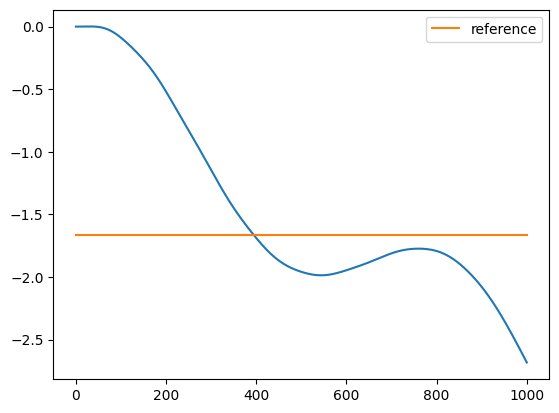

In [13]:
import matplotlib.pyplot as plt 

i = 5
plt.plot(controller_performance_sample.obs["obs"]["xpos_of_segment_end"][i])
plt.plot(controller_performance_sample.obs["ref"]["xpos_of_segment_end"][i], label="reference")
plt.legend()